In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
dataset_names={
    "celeba_attract": "CelebA",
    "old_adult": "Adult",       
    "employment":"ACSEmployment", 
    "adult_income":"ACSIncome", 
    "travel":"ACSTravelTime", 
    "coverage":"ACSPublicCoverage", 
    "mobility":"ACSMobility",   
    "german_age": "German Credit", 
    "diabetes_race":"Diabetes", 
}

metric_names={
    'acc':"Accuracy",
    'dp':"Demographic Parity",
    'eodds':"Equalized Odds",
    'eop':"Equal Opportunity"
}

metrics = ['acc', 'dp', 'eop', 'eodds']

In [37]:
def get_latex_table_caption_details(colors = ["blue!35", "blue!25", "blue!5", "orange!25", "orange!35"]):
    # Constructing the LaTeX string
    latex_string = r"The color range "

    # Add each color block with corresponding LaTeX commands
    for color in colors:
        latex_string += r"\textcolor{" + color + r"}{\raisebox{-0.3ex}{\rule{1em}{1em}}}"

    latex_string += (r" highlights the best (\textcolor{" + colors[0] + r"}{\raisebox{-0.3ex}{\rule{1em}{1em}}}) "
                    r"to the worst-performing method (\textcolor{" + colors[-1] + r"}{\raisebox{-0.3ex}{\rule{1em}{1em}}}) "
                    r"for fairness accuracy. $\uparrow$ indicates higher is better (accuracy) and "
                    r"$\downarrow$ lower is better (unfairness).")

    return latex_string



def get_merged_df(path):  
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    dfs = []
    for csv_file in csv_files[0:3]:
        df = pd.read_csv(os.path.join(path, csv_file)) * 100
        #df["acc"] = df.acc * 100
        dfs.append(df) 
        
    try:
        df = pd.concat(dfs, ignore_index=True) 
    except:
        print(f"Error with the file {path}")
    return df

def get_averaged_df(path):  
    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
    dfs = []
    for csv_file in csv_files: 
        df = pd.read_csv(os.path.join(path, csv_file))*100
        #df = df.iloc[12:]
        dfs.append(df)
    
    metrics = df.columns
    averaged = {}
    
    for metric in metrics: 
        averaged[metric] = []
        averaged[metric+"_std"] = []
        
    for metric in metrics:
        seed_dfs = [] 
        for df in dfs: 
            seed_dfs.append(df[metric].values)
        seed_dfs = np.array(seed_dfs) 
        averaged[metric] = seed_dfs.mean(axis=0)
        averaged[metric+"_std"] = seed_dfs.std(axis=0)

    return pd.DataFrame(averaged)

### Generate Latex table comparing different baselines

In [39]:
def compute_results(folder="analysis/results", datasets=["celeba_attract"], base_model="tabpfn", t_size=1000, cp=0.05, title=""): 
    """
    This function aggregates the results for the given datasets and base model.
    It also creates a LaTeX table with the results.

    Args:
        folder: The folder containing the results.
        datasets: The datasets to compute the results for.
        base_model: The base model to use.
        t_size: The training size to use.
    """
    
    print("\\begin{table*}[h]")
    print("\\begin{center}")
    print("\\resizebox{\\textwidth}{!}{")
    print("\\begin{tabular}{llcccc}")
    print("\\toprule")
    print("\\multicolumn{1}{l}{\\bf Dataset} & \\multicolumn{1}{l}{\\bf ICL Method} & \\multicolumn{1}{c}{\\bf Accuracy $\\uparrow$} & \\multicolumn{1}{c}{\\bf $\\Delta$ DP $\\downarrow$} & \\multicolumn{1}{c}{\\bf $\\Delta$ EOP $\\downarrow$} & \\multicolumn{1}{c}{\\bf $\\Delta$ EOD $\\downarrow$} \\\\")
    print("\\midrule") 
    baseline=f"/{base_model}"
    cp_ = cp 
    
    for dataset in datasets: 
        #base_folder = f"analysis/Ablation/Training_Size/{dataset}/t_size_{t_size}/{base_model}"
        base_folder = f"{folder}/{dataset}/t_size_{t_size}{baseline}" 
        #if dataset.startswith("compas"):
            #cp_ = 0.01 
            #t_size=-1 
        path_uncertain = f"{base_folder}/uncertain_lr/epsilon_{cp_}"
        path_uncertain_tabpfn = f"{base_folder}/uncertain_tabpfn/epsilon_{cp_}"
        path_random = f"{base_folder}/vanilla"
        path_balanced = f"{base_folder}/balanced"
        path_cr = f"{base_folder}/correlation_remover/alpha_1.0"
        
        #df_certain = get_merged_df(path_certain)
        df_random = get_merged_df(path_random) 
        df_uncertain = get_merged_df(path_uncertain)
        df_balanced = get_merged_df(path_balanced)
        df_cr = get_merged_df(path_cr)

        df_uncertain_tabpfn = get_merged_df(path_uncertain_tabpfn)
        
        #methods = {'Random': df_random, 'Balanced': df_balanced, "Correlation R.":df_cr, "Uncertain+TabPFN": df_uncertain_tabpfn}
        
        methods = {'\\acrlong{vanilla}': df_random, '\\acrlong{balanced}': df_balanced, "\\acrlong{correlation_r}":df_cr, '\\acrlong{uncert_lr}': df_uncertain, "\\acrlong{uncert_tabpfn}": df_uncertain_tabpfn}
        
        

        #print(f"\\multirow{{{len(methods)}}}{{*}}{{{dataset_names[dataset]}}} & ", end="")
        print(f"\\multirow{{{len(methods)}}}{{*}}{{\\acrshort{{{dataset_names[dataset]}}}}} & ", end="")
        for i, (method, df) in enumerate(methods.items()):
            means = [f"{df[m].mean():.2f}" for m in metrics]
            stds = [f"{df[m].std():.1f}" for m in metrics]
            
            # Find best and worst values for each metric
            acc_values = [(df_name, df['acc'].mean()) for df_name, df in methods.items()]
            dp_values = [(df_name, df['dp'].mean()) for df_name, df in methods.items()]
            eop_values = [(df_name, df['eop'].mean()) for df_name, df in methods.items()]
            eodds_values = [(df_name, df['eodds'].mean()) for df_name, df in methods.items()]
            
            # Sort by accuracy (descending) and fairness metrics (ascending)
            acc_values.sort(key=lambda x: x[1], reverse=True)
            dp_values.sort(key=lambda x: x[1])
            eop_values.sort(key=lambda x: x[1])
            eodds_values.sort(key=lambda x: x[1])
            
            if i > 0:
                print("& ", end="")
            color_range = ["blue!35", "blue!25", "blue!5", "orange!25", "orange!35"]
            # Color from orange (worst) to white (middle) to blue (best)
            for j, metric_values in enumerate([(acc_values, True), (dp_values, False), (eop_values, False), (eodds_values, False)]):
                values, is_higher_better = metric_values
                val_pos = {} 
                vals=[f"{i[1]:.2f}" for i in values] 
                for i, v in enumerate(vals):
                    if v not in val_pos.keys():
                        val_pos[v] = i
                #print(val_pos)
                means[j] = f"\\cellcolor{{{color_range[val_pos[means[j]]]}}}{means[j]}"     
                
            print(f"{method} & ${means[0]}_{{\pm{stds[0]}}}$ & ${means[1]}_{{\pm{stds[1]}}}$ & ${means[2]}_{{\pm{stds[2]}}}$ & ${means[3]}_{{\pm{stds[3]}}}$ \\\\")
            
        if dataset != datasets[-1]:
            print("\\midrule")
         
    print("\\bottomrule")
    print("\\end{tabular}")
    print("}") 
    print("\\end{center}") 
    print(f"\\caption{{This table supplements Figure~\\ref{{fig:main_results}} in main paper. {title} of ICL predictions with \\acrshort{{{base_model}}} as foundation model under different preprocessing methods. {get_latex_table_caption_details(color_range)} }}\\label{{tab:fairness-accuracy-{base_model}-{title.replace(' ', '_')}}}")
    print("\\end{table*}")

base_model = 'tabpfn'

compute_results(datasets=["adult_income", "employment", "coverage", "travel", "mobility", "diabetes_race", "german_age", "celeba_attract"], base_model=base_model, t_size=-1, cp=0.05, title=" It shows the accuracy and fairness performance") 

\begin{table*}[h]
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llcccc}
\toprule
\multicolumn{1}{l}{\bf Dataset} & \multicolumn{1}{l}{\bf ICL Method} & \multicolumn{1}{c}{\bf Accuracy $\uparrow$} & \multicolumn{1}{c}{\bf $\Delta$ DP $\downarrow$} & \multicolumn{1}{c}{\bf $\Delta$ EOP $\downarrow$} & \multicolumn{1}{c}{\bf $\Delta$ EOD $\downarrow$} \\
\midrule
\multirow{5}{*}{\acrshort{ACSIncome}} & \acrlong{vanilla} & $\cellcolor{orange!25}80.85_{\pm0.5}$ & $\cellcolor{orange!25}14.17_{\pm1.2}$ & $\cellcolor{blue!5}5.18_{\pm2.6}$ & $\cellcolor{blue!5}5.66_{\pm2.0}$ \\
& \acrlong{balanced} & $\cellcolor{blue!25}80.94_{\pm0.4}$ & $\cellcolor{blue!5}14.09_{\pm1.6}$ & $\cellcolor{orange!25}5.43_{\pm3.3}$ & $\cellcolor{orange!25}5.91_{\pm2.8}$ \\
& \acrlong{correlation_r} & $\cellcolor{blue!35}81.40_{\pm0.5}$ & $\cellcolor{orange!35}26.55_{\pm1.9}$ & $\cellcolor{orange!35}27.11_{\pm5.5}$ & $\cellcolor{orange!35}27.11_{\pm5.5}$ \\
& \acrlong{uncert_lr} & $\cellcolor{blue!5}80.92

### Generate bar plots comparing different baselines

/var/folders/sp/0m880m5157b6tv_z__l6jmtm0000gn/T/ipykernel_49464/2104152635.py:148: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


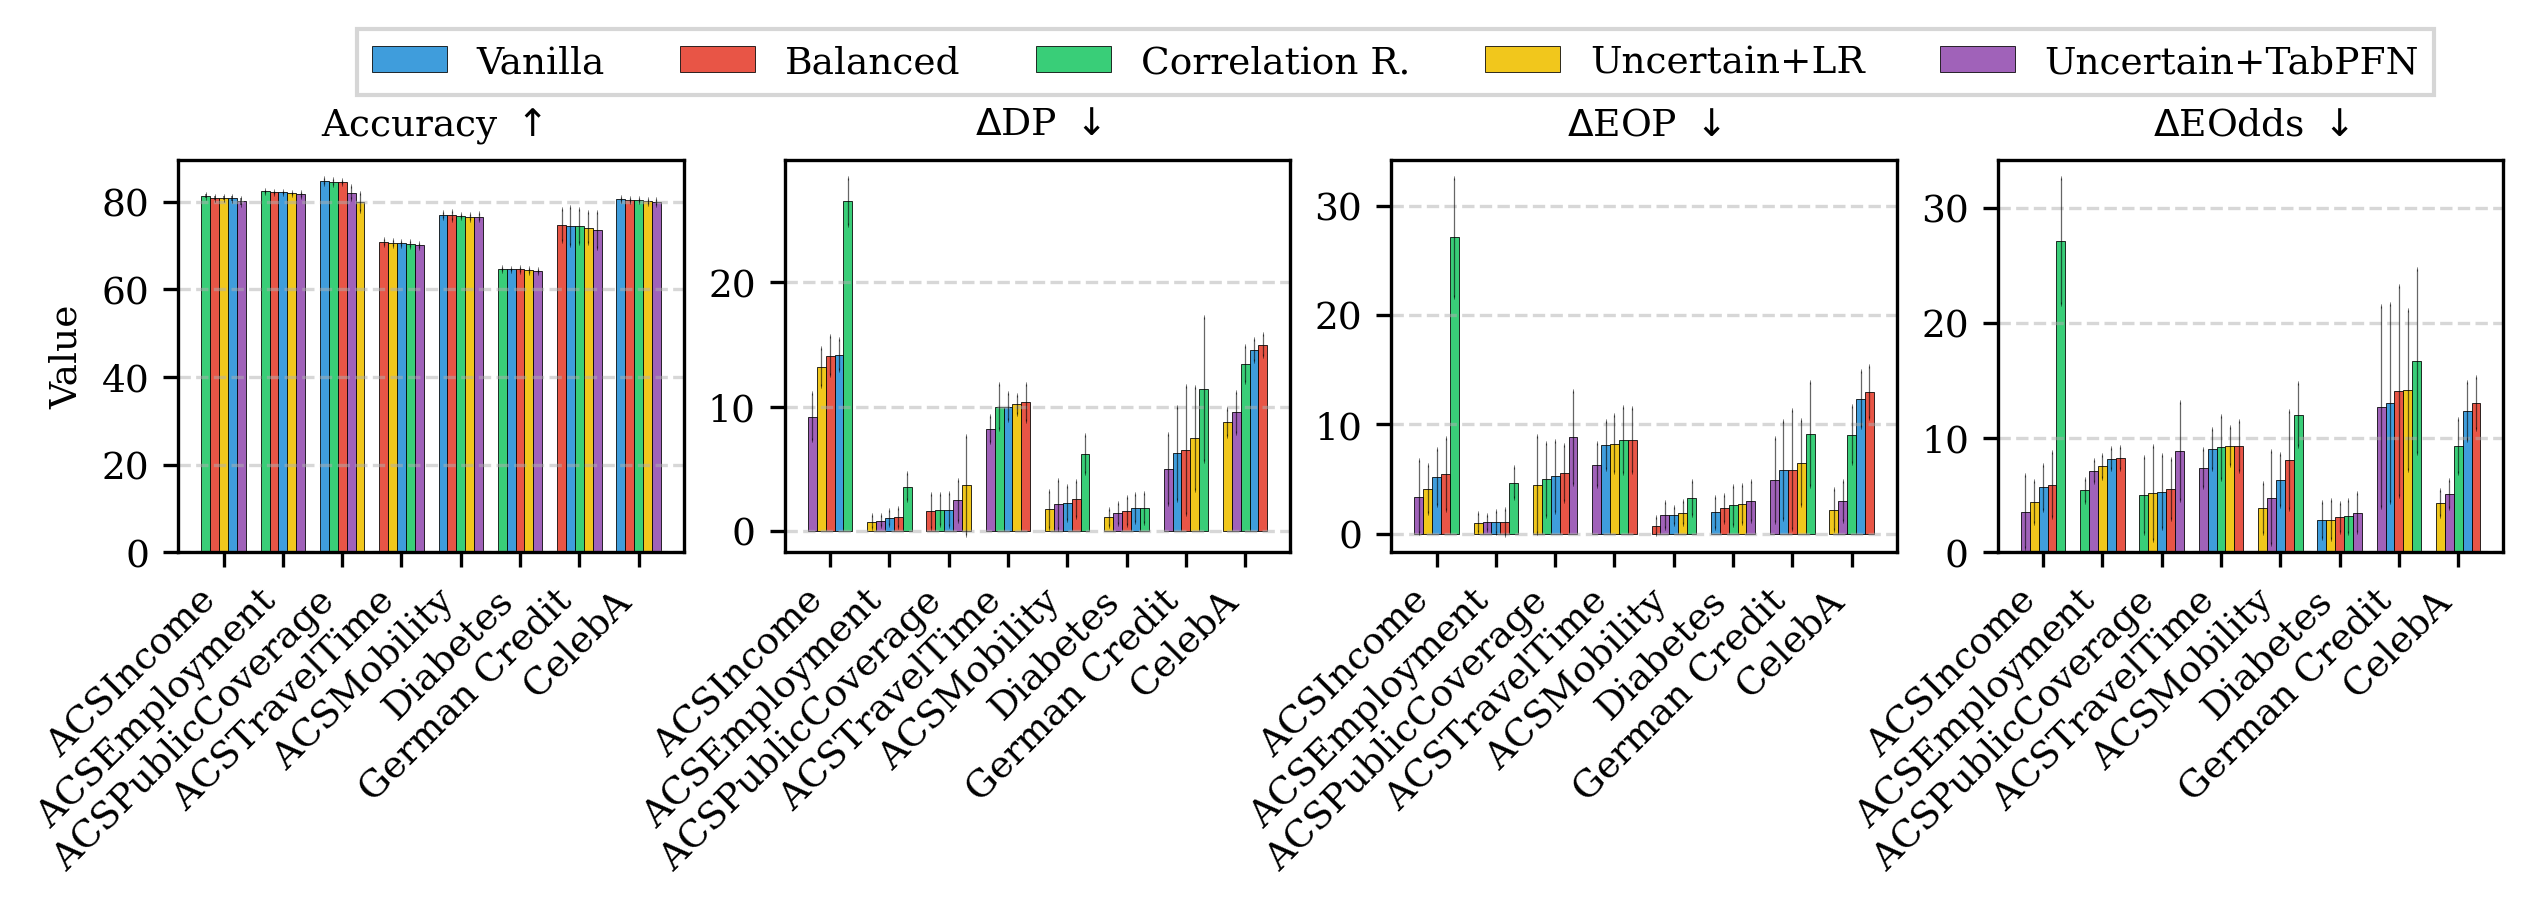

In [38]:
def compute_results_bar_plot(folder="analysis/results", datasets=["celeba_attract"], base_model="tabpfn", t_size=1000, cp=0.05, title=""): 
    """
    This function computes the results for the given datasets and base model.
    Similar to the function compute_results_table, but generates a bar plot instead of a Latex table.
    """
    
    # Set publication-quality figure parameters
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 9,  # font size
        'axes.labelsize': 9,  # label size
        'axes.titlesize': 9,  # title size
        'xtick.labelsize': 9,  # tick label size
        'ytick.labelsize': 9,  # tick label size
        'legend.fontsize': 9,  # legend font size
        'figure.dpi': 300,
        'savefig.dpi': 300
    })
    
    baseline = f"/{base_model}"
    cp_ = cp
    
    # Create a figure with 4 subplots (accuracy, DP, EOP, EOdds)
    fig, axes = plt.subplots(1, 4, figsize=(10, 1.7))
    metric_names = ["Accuracy", "$\Delta$DP", "$\Delta$EOP", "$\Delta$EOdds"]
    metric_directions = ["$\\uparrow$", "$\downarrow$", "$\downarrow$", "$\downarrow$"]
    
    all_results = {}
    
    for dataset in datasets: 
        base_folder = f"{folder}/{dataset}/t_size_{t_size}{baseline}" 

        path_uncertain = f"{base_folder}/uncertain_lr/epsilon_{cp_}"
        path_uncertain_tabpfn = f"{base_folder}/uncertain_tabpfn/epsilon_{cp_}"
        path_random = f"{base_folder}/vanilla"
        path_balanced = f"{base_folder}/balanced"
        path_cr = f"{base_folder}/correlation_remover/alpha_1.0"
        
        df_random = get_merged_df(path_random) 
        df_uncertain = get_merged_df(path_uncertain)
        df_balanced = get_merged_df(path_balanced)
        df_cr = get_merged_df(path_cr)
        df_uncertain_tabpfn = get_merged_df(path_uncertain_tabpfn)
        
        
        methods = {
            'Vanilla': df_random, 
            'Balanced': df_balanced, 
            "Correlation R.": df_cr, 
            'Uncertain+LR': df_uncertain, 
            "Uncertain+TabPFN": df_uncertain_tabpfn
        }
        
        dataset_results = {}
        
        for method, df in methods.items():
            means = [df[m].mean() for m in metrics]
            stds = [df[m].std() for m in metrics]
            
            dataset_results[method] = {
                'means': means,
                'stds': stds
            }
        
        all_results[dataset] = dataset_results
    
    # Sort datasets by fairness metrics
    sorted_datasets = {}
    for metric_idx in range(1, 4):  # DP, EOP, EOdds
        # Calculate average unfairness value for each dataset
        dataset_values = []
        for dataset in datasets:
            avg_value = np.mean([all_results[dataset][method]['means'][metric_idx] for method in methods.keys()])
            dataset_values.append((dataset, avg_value))
        
        # Sort datasets by decreasing unfairness value
        #sorted_datasets[metric_idx] = [d for d, _ in sorted(dataset_values, key=lambda x: x[1], reverse=True)]
    
    # Assign consistent colors to methods with higher contrast
    method_colors = {
        'Vanilla': '#3498db',         # Bright blue
        'Balanced': '#e74c3c',        # Bright red
        'Correlation R.': '#2ecc71',  # Green
        'Uncertain+LR': '#f1c40f',    # Yellow
        'Uncertain+TabPFN': '#9b59b6' # Purple
    }
    
    # Plot the results
    for metric_idx in range(4):  # Plot Acc, DP, EOP, EOdds
        ax = axes[metric_idx]
        
        # Set up the plot
        ax.set_title(f"{metric_names[metric_idx]} {metric_directions[metric_idx]}", fontsize=9)
        if metric_idx == 0:
            ax.set_ylabel("Value", fontsize=9)
        
        # Use original dataset order for accuracy, sorted order for fairness metrics
        plot_datasets = datasets #if metric_idx == 0 else sorted_datasets[metric_idx]
        
        # Calculate positions for bars
        num_datasets = len(plot_datasets)
        num_methods = len(methods)
        bar_width = 0.15  # Slightly reduced for better separation
        index = np.arange(num_datasets)
        
        # For each dataset
        for dataset_idx, dataset in enumerate(plot_datasets):
            # Get method order for this dataset and metric 
            method_values = [(method, all_results[dataset][method]['means'][metric_idx]) 
                            for method in methods.keys()]
            sorted_methods = [m for m, _ in sorted(method_values, key=lambda x: x[1], reverse=metric_idx == 0)] 
            
            # Plot bars for each method in the sorted order for this dataset
            for i, method in enumerate(methods.keys()):
                value = all_results[dataset][method]['means'][metric_idx]
                error = all_results[dataset][method]['stds'][metric_idx]
                
                # Find position of this method in the sorted order
                method_idx = sorted_methods.index(method)
                position = dataset_idx + (method_idx - num_methods/2 + 0.5) * bar_width
                
                # Use consistent color for each method with higher opacity
                if dataset_idx == 0 and metric_idx == 0:  # Only add label once
                    ax.bar(position, value, bar_width, label=method, color=method_colors[method], alpha=0.95,
                           yerr=error, capsize=0.1, edgecolor='black', linewidth=0.2,
                           error_kw={'elinewidth': 0.4, 'ecolor': 'black', 'alpha': 0.6})
                else:
                    ax.bar(position, value, bar_width, color=method_colors[method], alpha=0.95,
                           yerr=error, capsize=0.1, edgecolor='black', linewidth=0.2,
                           error_kw={'elinewidth': 0.3, 'ecolor': 'black', 'alpha': 0.6})
        
        # Set x-ticks and labels
        ax.set_xticks(index)
        ax.set_xticklabels([dataset_names[d] for d in plot_datasets], rotation=45, ha='right', fontsize=9)
        
        # Add legend with better positioning
        if metric_idx == 0:
            ax.legend(loc='best', bbox_to_anchor=(4.5, 1.38), ncol=num_methods, frameon=True, fancybox=False, shadow=False)
        
        # Add grid with lighter lines for better visibility of bars
        ax.grid(True, linestyle='--', alpha=0.5, axis='y')
        
        # Add spines for better definition
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(0.8)
    
    plt.tight_layout()
    plt.subplots_adjust()  # bottom=0.10
    #plt.savefig("instance/plots/bar_plot.pdf", format="pdf", bbox_inches="tight", dpi=300)
    # Add a title for the entire figure
    #fig.suptitle(f"{title} for ICL prediction with {base_model.upper()} as foundation model", fontsize=20)
    
    #return fig

base_model = 'tabpfn'
datasets=["adult_income", "employment", "coverage", "travel", "mobility", "diabetes_race", "german_age", "celeba_attract"]
#compute_results_bar_plot(datasets=["german_age", "diabetes_race", "celeba_attract"], base_model=base_model, t_size=-1, cp=0.05, title="Accuracy and fairness performance") 
compute_results_bar_plot(datasets=datasets, base_model=base_model, t_size=-1, cp=0.05, title="Accuracy and fairness performance") 

### Fairness-accuracy tradeoff plots

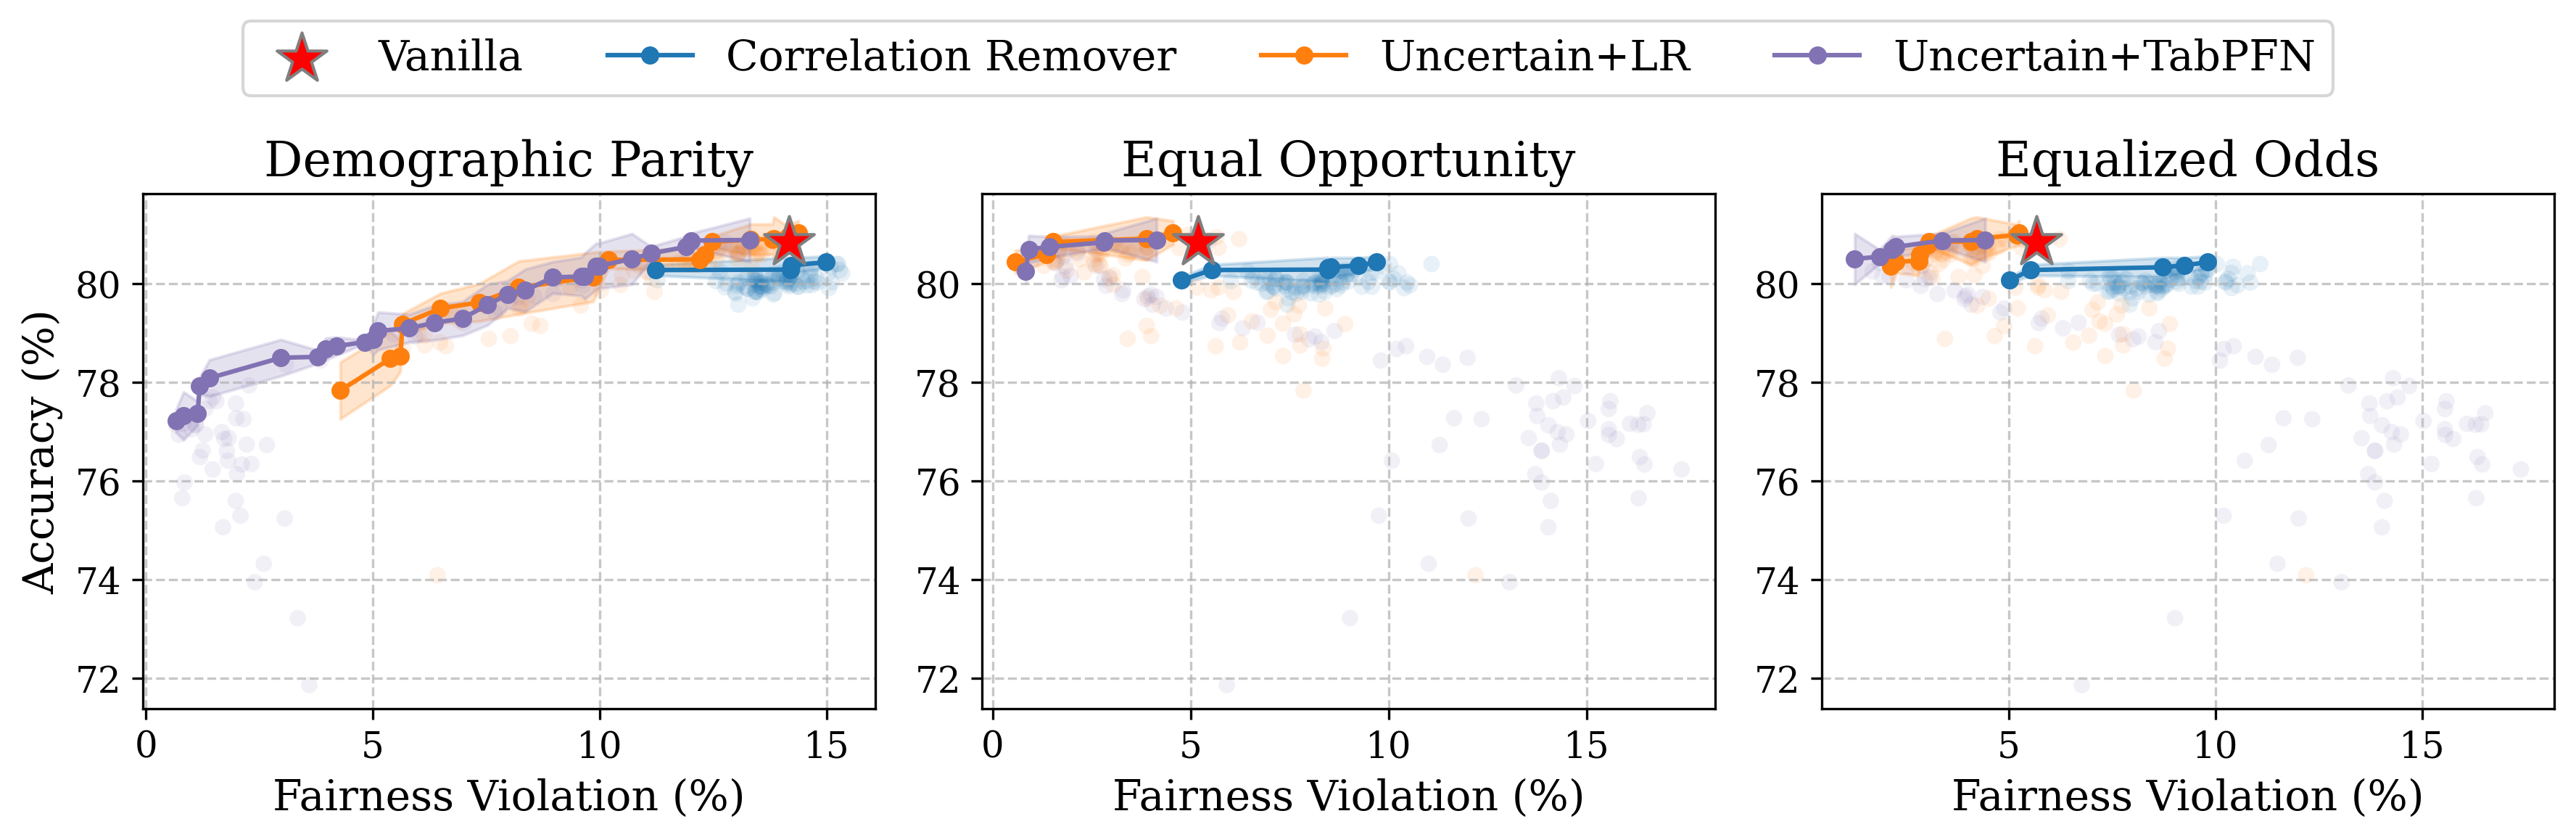

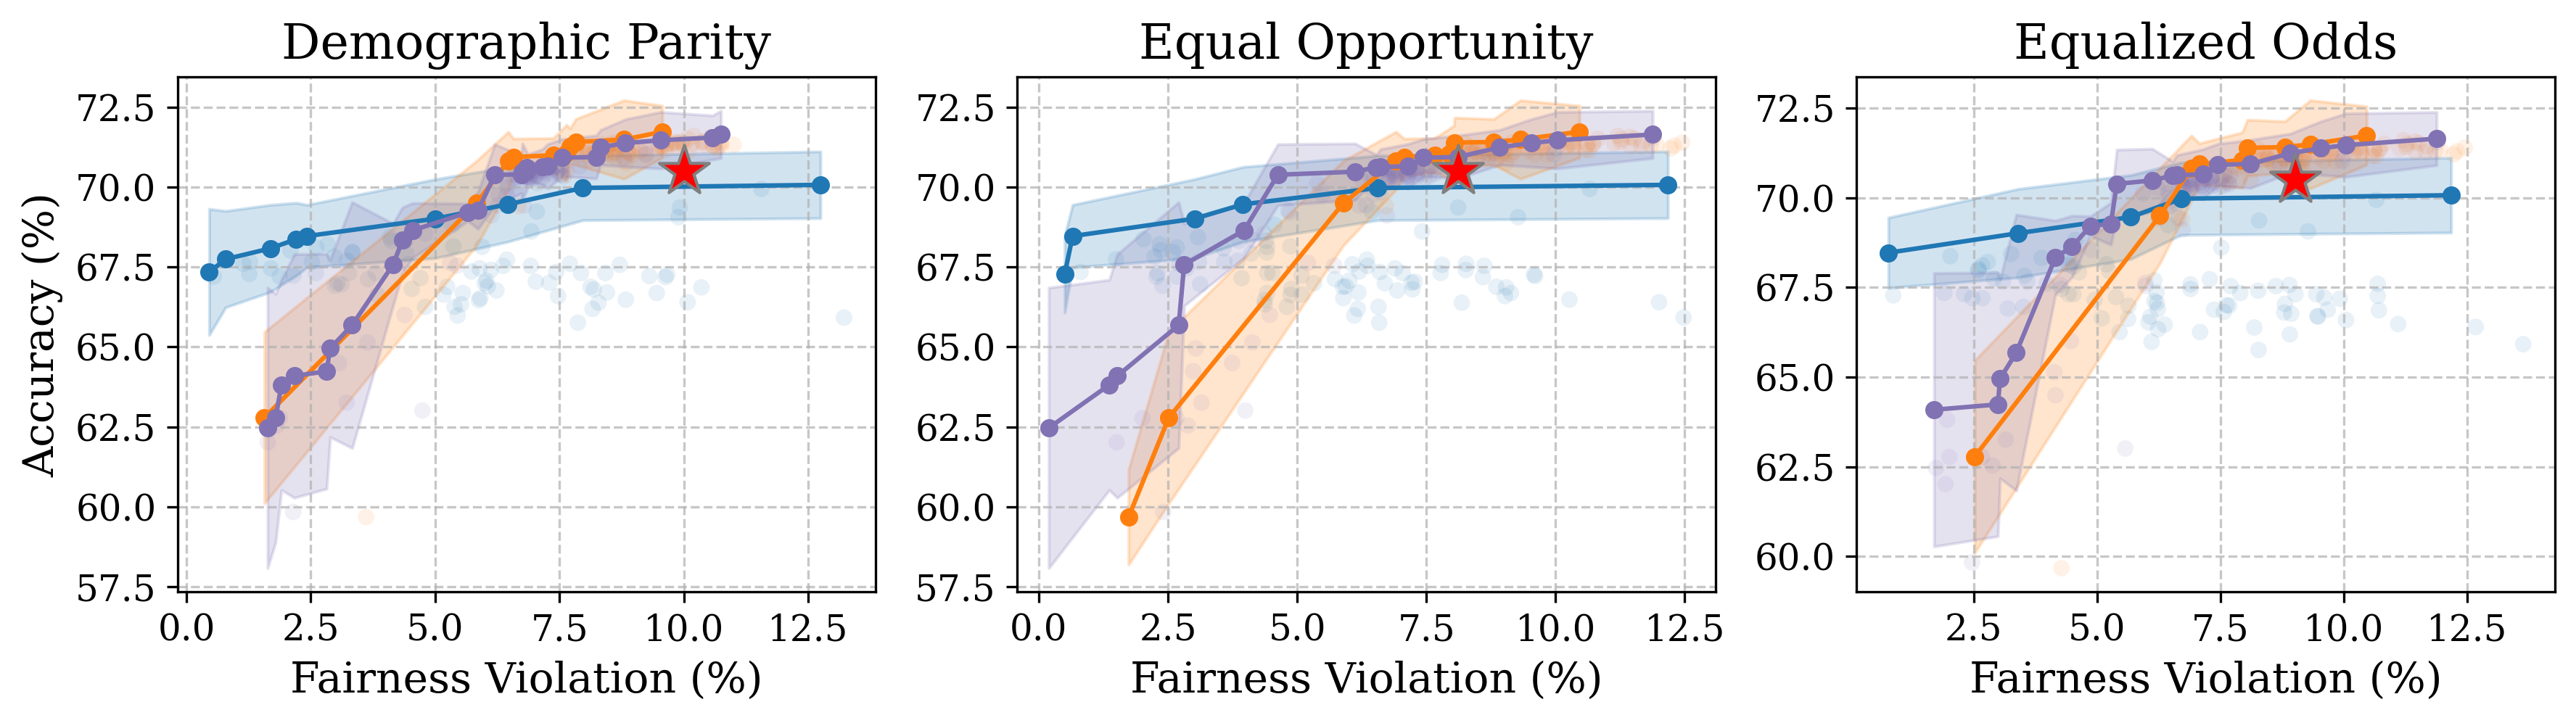

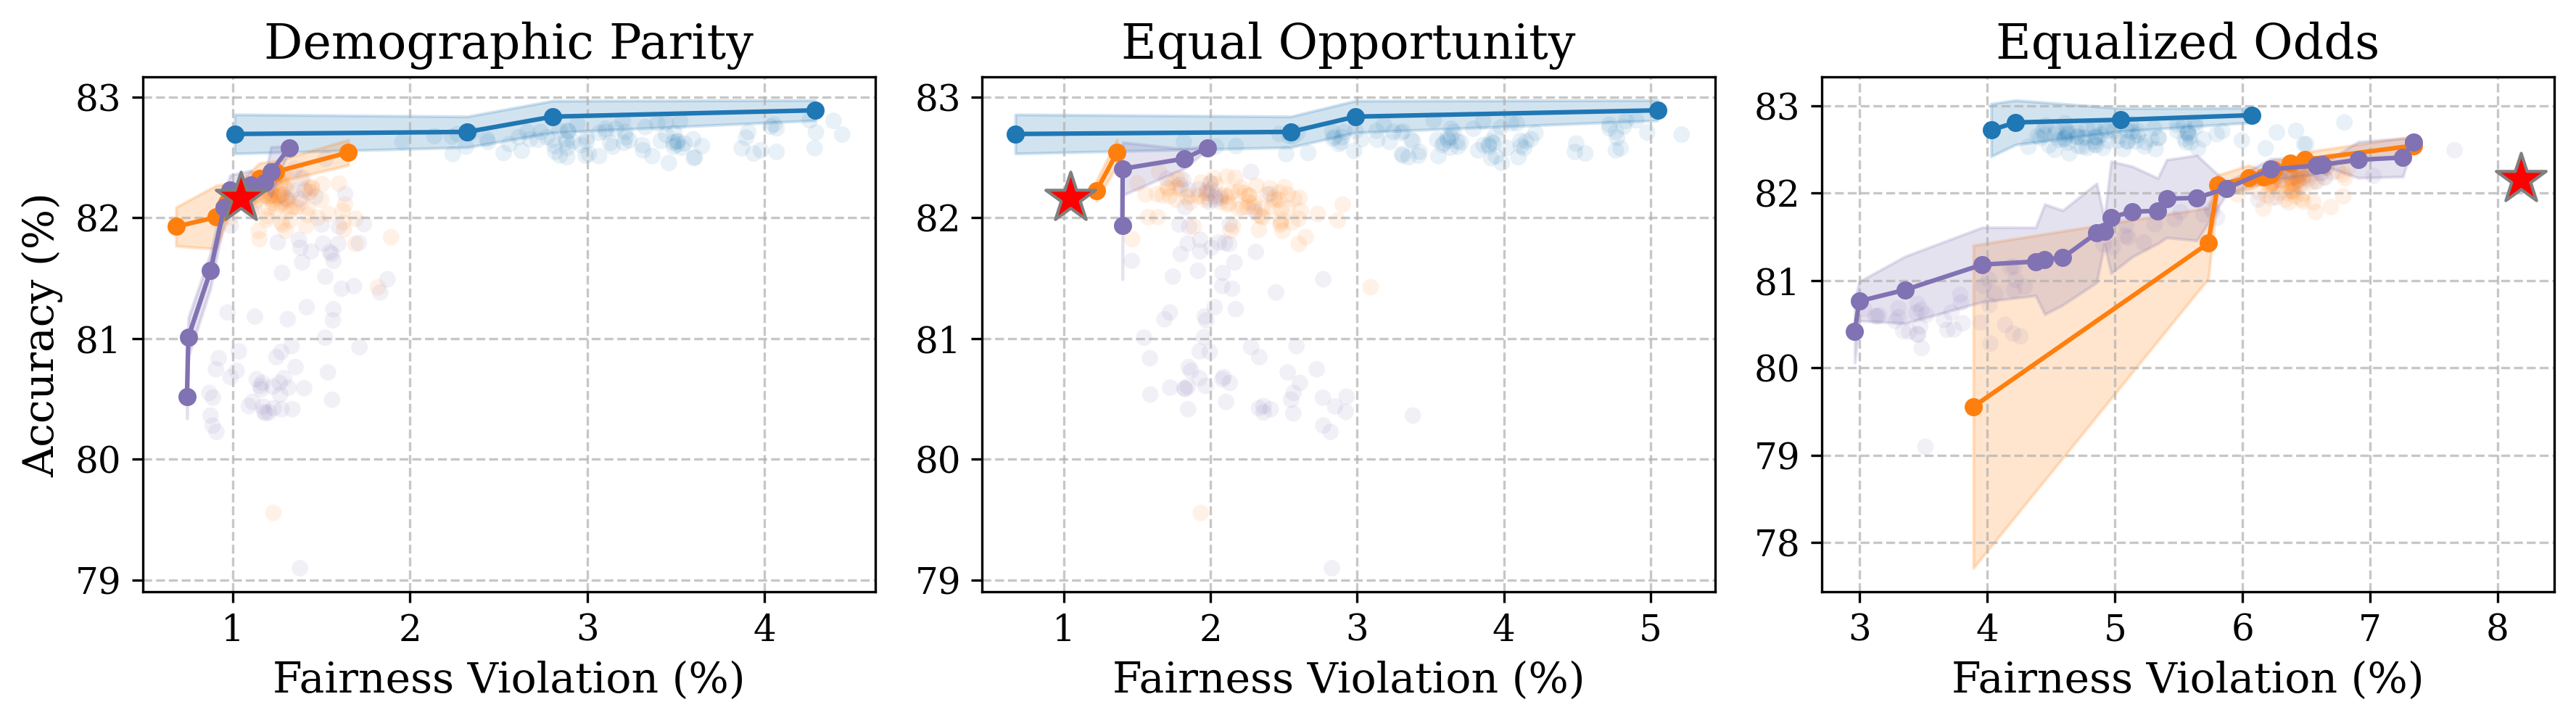

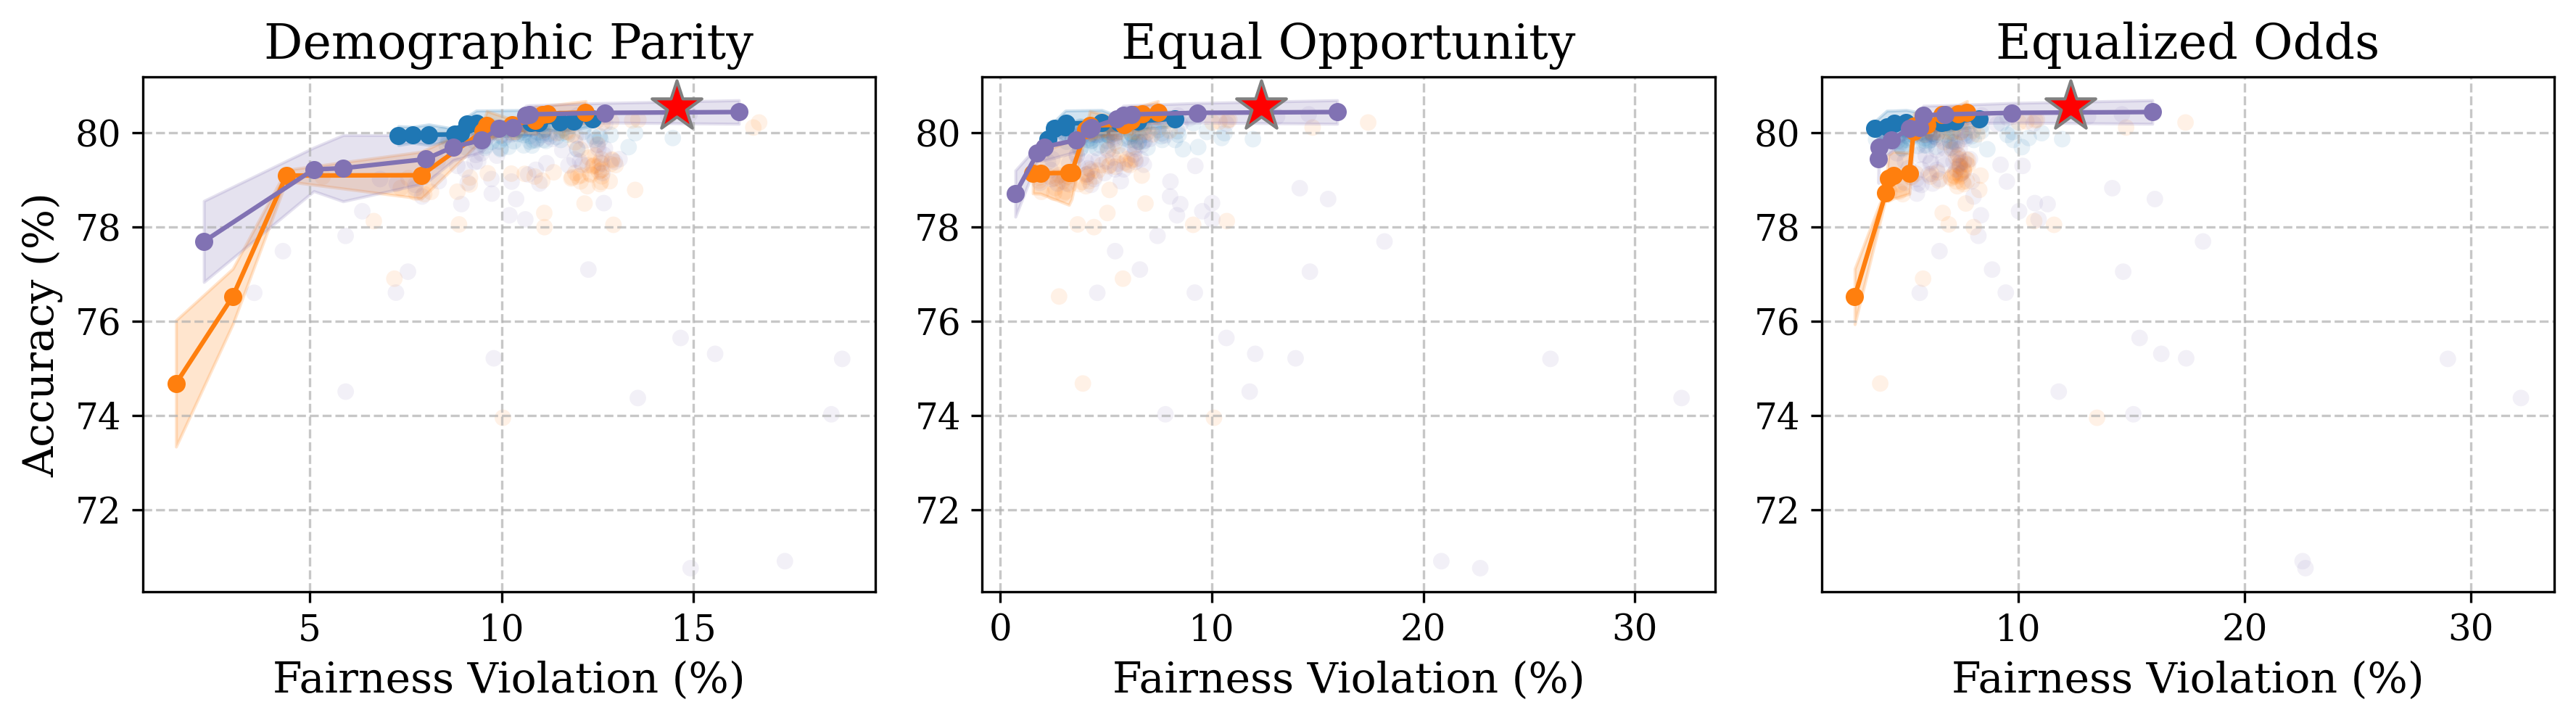

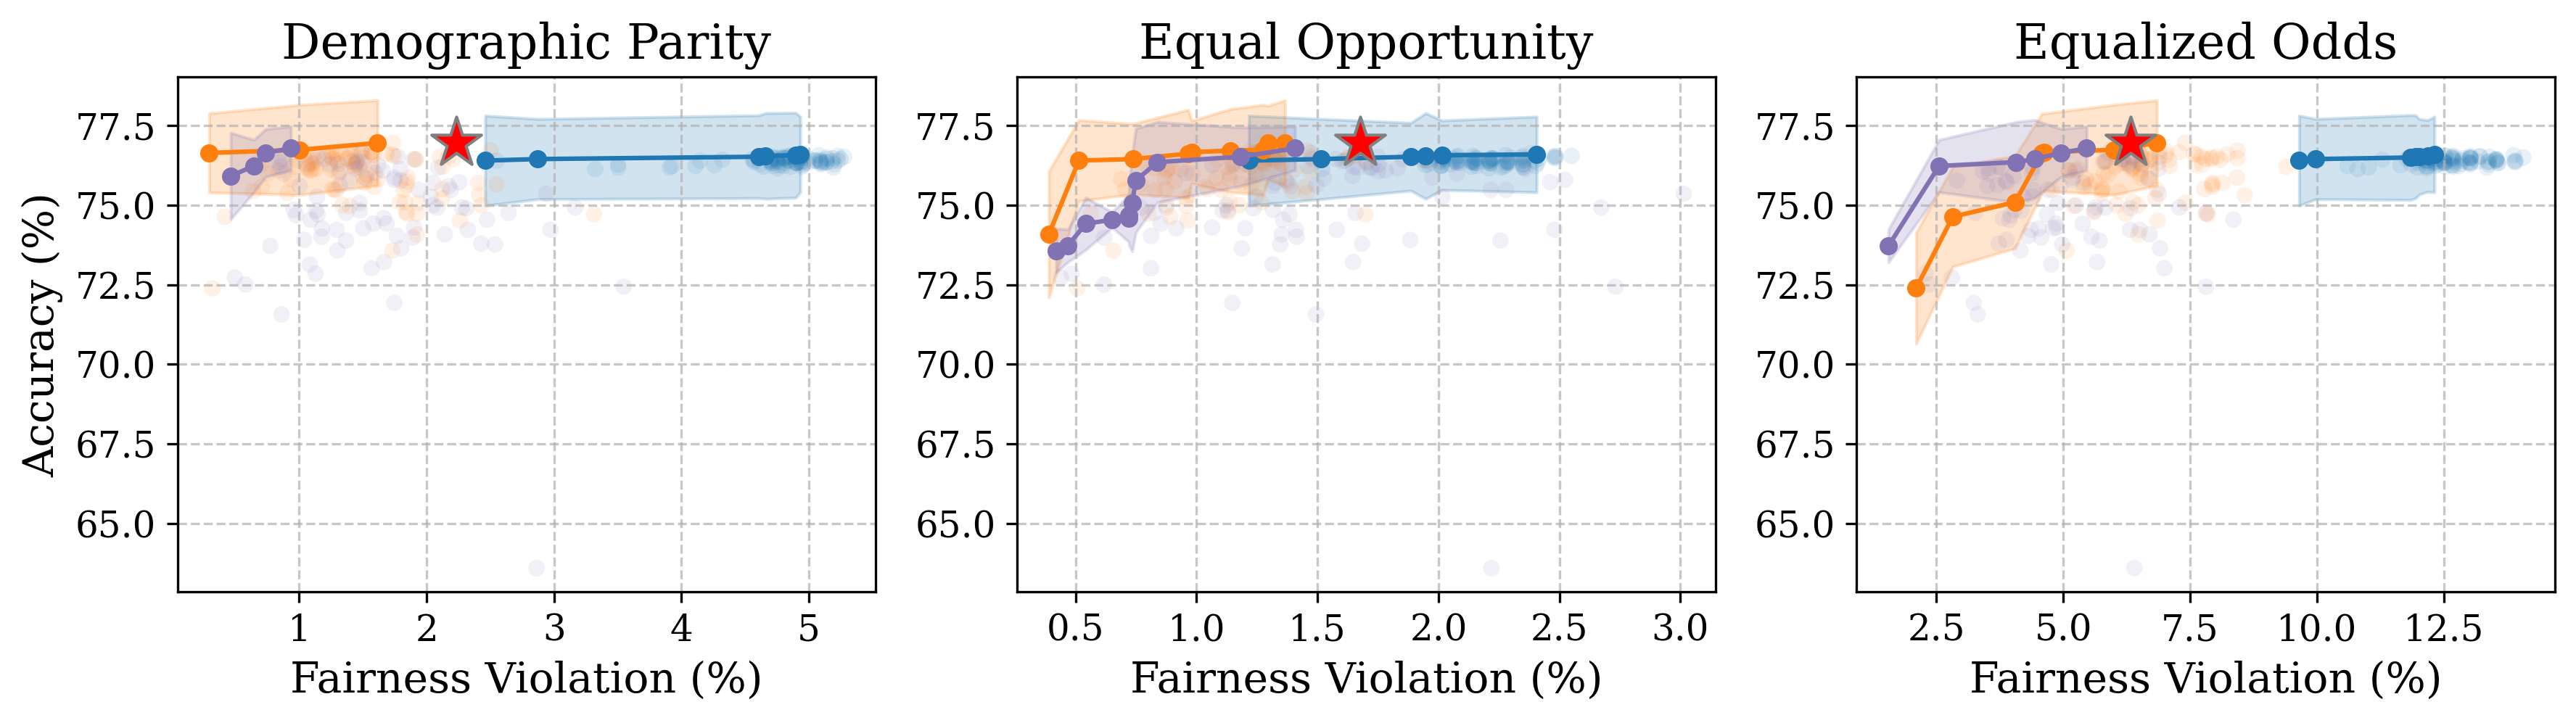

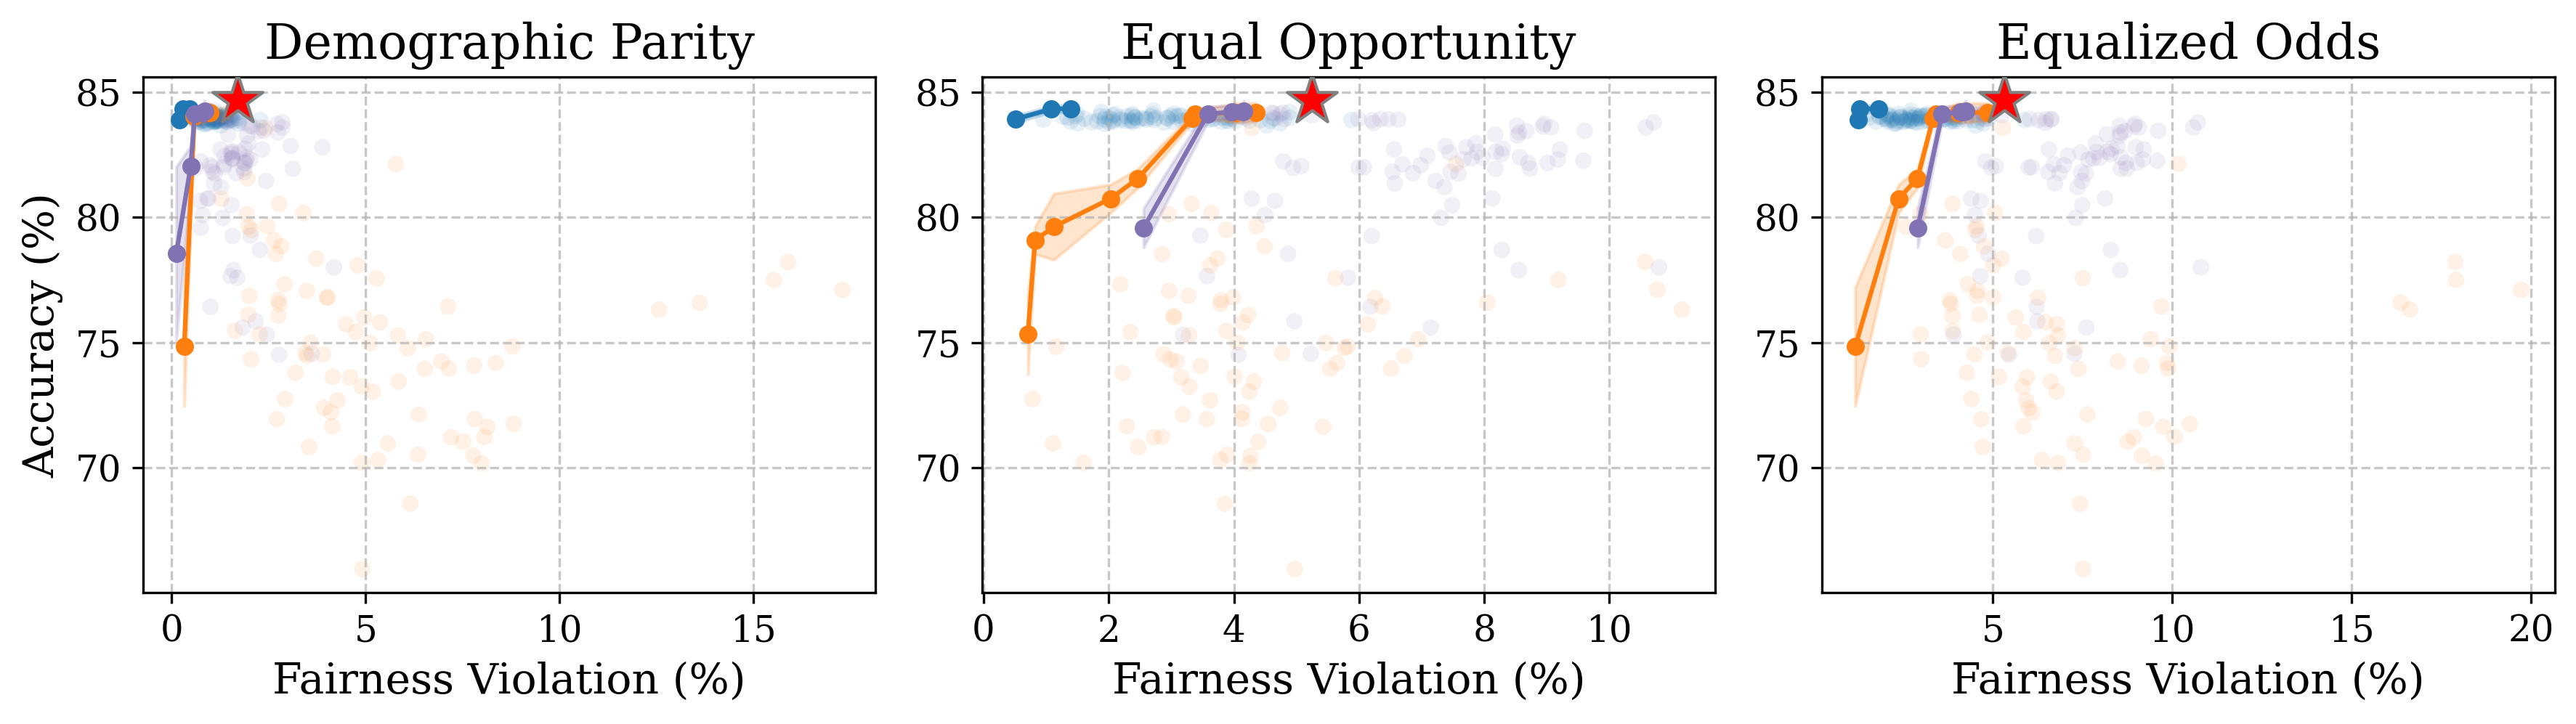

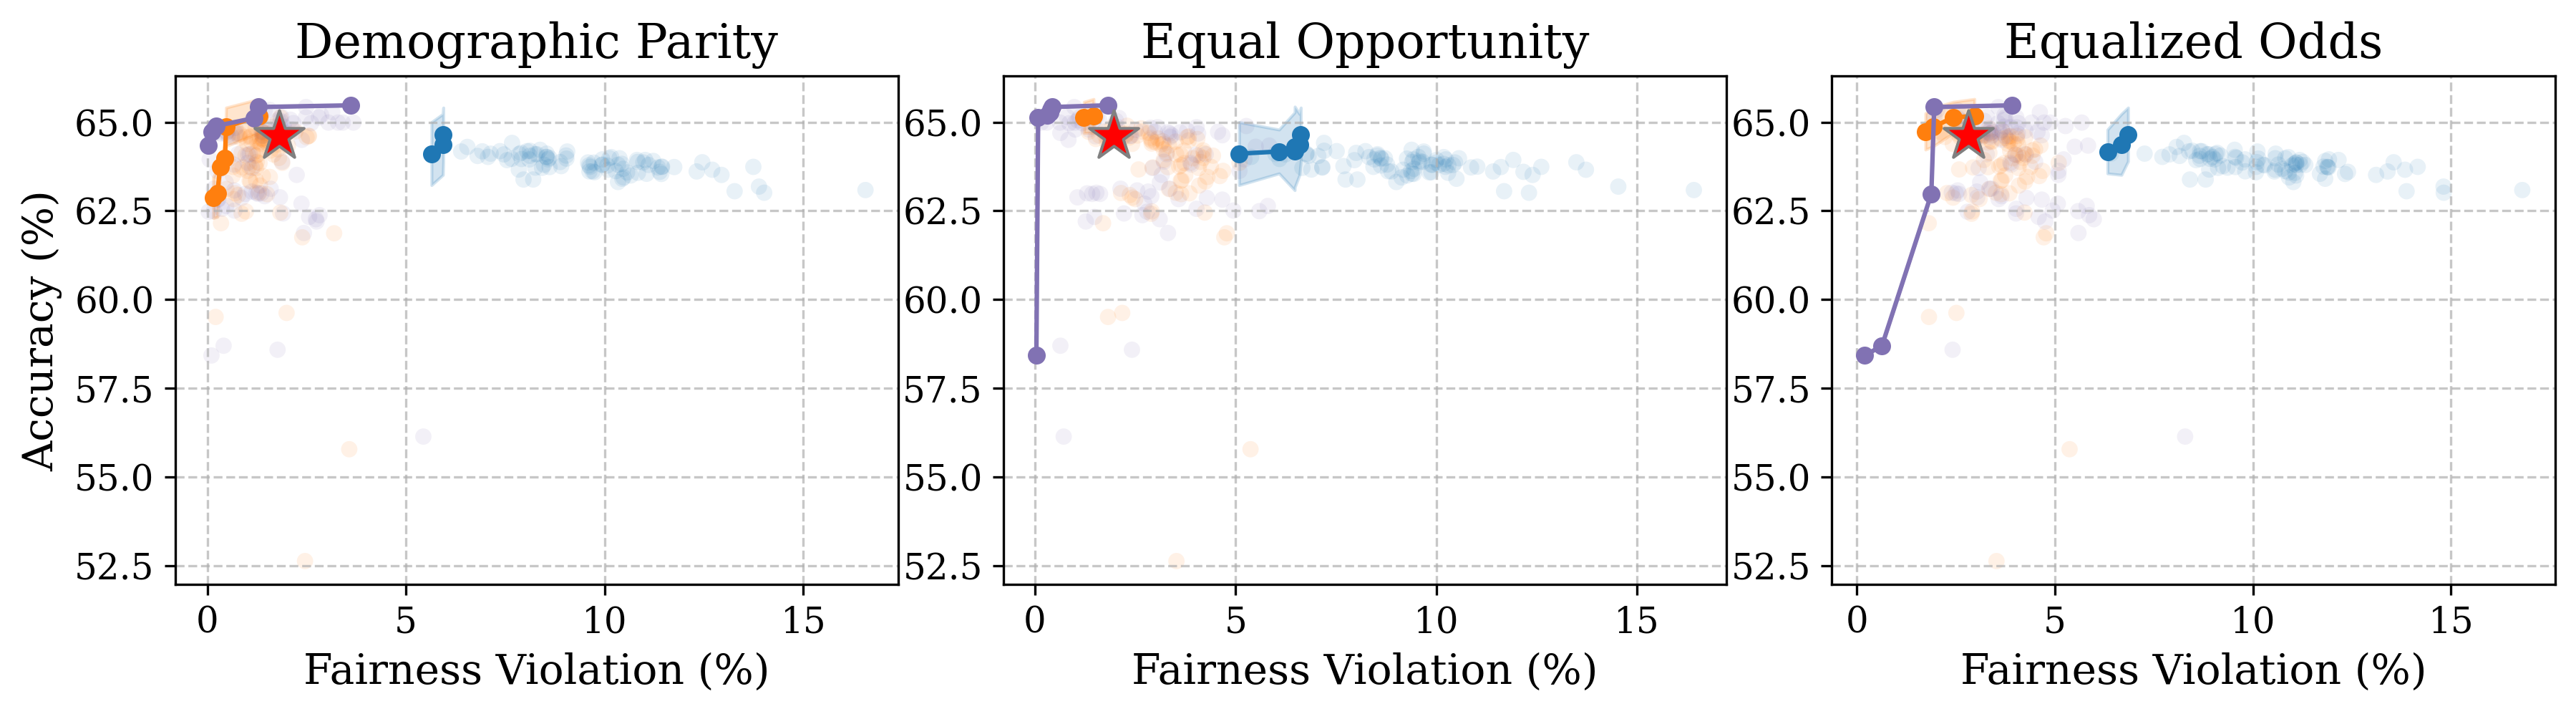

In [26]:
def is_pareto_efficient(costs, return_mask = True):
    #source: https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient


def plot_pareto_front(dataset = "adult", base_model="tabpfn"):
    path_cr = f"analysis/tradeoff/{dataset}/t_size_-1/{base_model}/correlation_remover"
    path_uncert_pfn = f"analysis/tradeoff/{dataset}/t_size_-1/{base_model}/uncertain_tabpfn"
    path_uncert_lr = f"analysis/tradeoff/{dataset}/t_size_-1/{base_model}/uncertain_lr"  
    path_random = f"analysis/results/{dataset}/t_size_-1/{base_model}/vanilla"
    path_group_balanced = f"analysis/results/{dataset}/t_size_-1/{base_model}/balanced"

    df_random = get_merged_df(path_random) 
    df_group_balanced = get_merged_df(path_group_balanced)

    methods = {
        "Correlation Remover": path_cr,
        "Uncertain+LR": path_uncert_lr,
        "Uncertain+TabPFN": path_uncert_pfn,
        #"Uncertain+MLP": path_uncert_mlp,
    }
    
    def plot_front(averaged_df, fairness_metric, ax, method, color):
        acc_metric = "acc"
        accuracies = averaged_df[acc_metric]
        fairness = averaged_df[fairness_metric] 

        # For Pareto front, we want to maximize accuracy and minimize fairness violation
        errors = 1.0 - accuracies
        pareto_input = np.array([[error, unfair] for (error, unfair) in zip(errors, fairness)])
        
        # Get Pareto efficient points
        is_efficient = is_pareto_efficient(pareto_input)
        pareto_df = averaged_df.iloc[is_efficient].copy()
        
        # Sort by fairness metric for proper line drawing
        pareto_df = pareto_df.sort_values(by=fairness_metric)
        
        # Plot all points with transparency
        ax.scatter(averaged_df[fairness_metric], averaged_df[acc_metric], 
                  alpha=0.1, color=color, s=30, edgecolor='none')
         

         

        # Plot Pareto front with solid line and markers
        ax.plot(pareto_df[fairness_metric], pareto_df[acc_metric], 
               '-o', label=method, linewidth=1.5, markersize=5, color=color)
        
        # Add error bands for accuracy
        ax.fill_between(
            pareto_df[fairness_metric],
            pareto_df[acc_metric] - pareto_df[acc_metric+"_std"],
            pareto_df[acc_metric] + pareto_df[acc_metric+"_std"],
            alpha=0.2, color=color
        ) 

        return pareto_df
    
    metrics = ['dp', 'eop', 'eodds']
    metric_labels = ['Demographic Parity', 'Equal Opportunity', 'Equalized Odds']
    
    # Set up figure with better aesthetics
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
    
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 14,
        'figure.dpi': 300,
        'savefig.dpi': 300
    })
    
    colors = ['#1f77b4', '#ff7f0e', '#8172B3', '#d62728']
    #colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B3']
    
    
    for i, (method, path) in enumerate(methods.items()):
        averaged = get_averaged_df(path).copy() 
        for ax_idx, (ax, metric, metric_label) in enumerate(zip(axes, metrics, metric_labels)): 
            # Add a star marker for the random baseline if we're on the first method
            #if i == 0 and 'df_random' in globals():
            # Calculate mean accuracy and fairness metric for random
            if i == 0:
                mean_acc = df_random['acc'].mean()
                mean_metric = df_random[metric].mean()
                # Plot star marker for random baseline
                ax.scatter(mean_metric , mean_acc, marker='*', s=300, 
                            color='red', edgecolor='gray', label='Vanilla' if ax_idx == 0 else None, zorder=10)
            
            
            # Plot the Pareto front for the method
            plot_front(averaged, metric, ax, method, colors[i])
            # Improve axis labels and appearance
            #ax.set_xlabel(f"{metric_label} Violation")
            ax.set_xlabel(f"Fairness Violation (%)")
            if ax_idx == 0:
                ax.set_ylabel("Accuracy (%)")
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_title(metric_label)
            
            
            
            # Set reasonable axis limits
            #ax.set_ylim(averaged['acc'].min() - 0.5, min(100, averaged['acc'].max() + 2.0))
            
    # Add a common legend at the bottom
    handles, labels = axes[0].get_legend_handles_labels()
    #fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(methods))

    if dataset == "adult_income" or (base_model== "tabicl" and dataset=="travel"):
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.13), 
                ncol=len(methods)+1, frameon=True, fancybox=True) 
    
    #plt.savefig(f"plots/tradeoff/pareto_front_{base_model}_{dataset}.pdf", bbox_inches='tight')
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    

base_model="tabpfn"
datasets = ["adult_income", "travel", "employment", "celeba_attract", "mobility", "coverage", "diabetes_race"]
#datasets = ["diabetes_race"]
for dataset in datasets:
    plot_pareto_front(dataset=dataset, base_model=base_model)  

### Fairness-accuracy tradeoff comparison of TabPFN and TabICL 

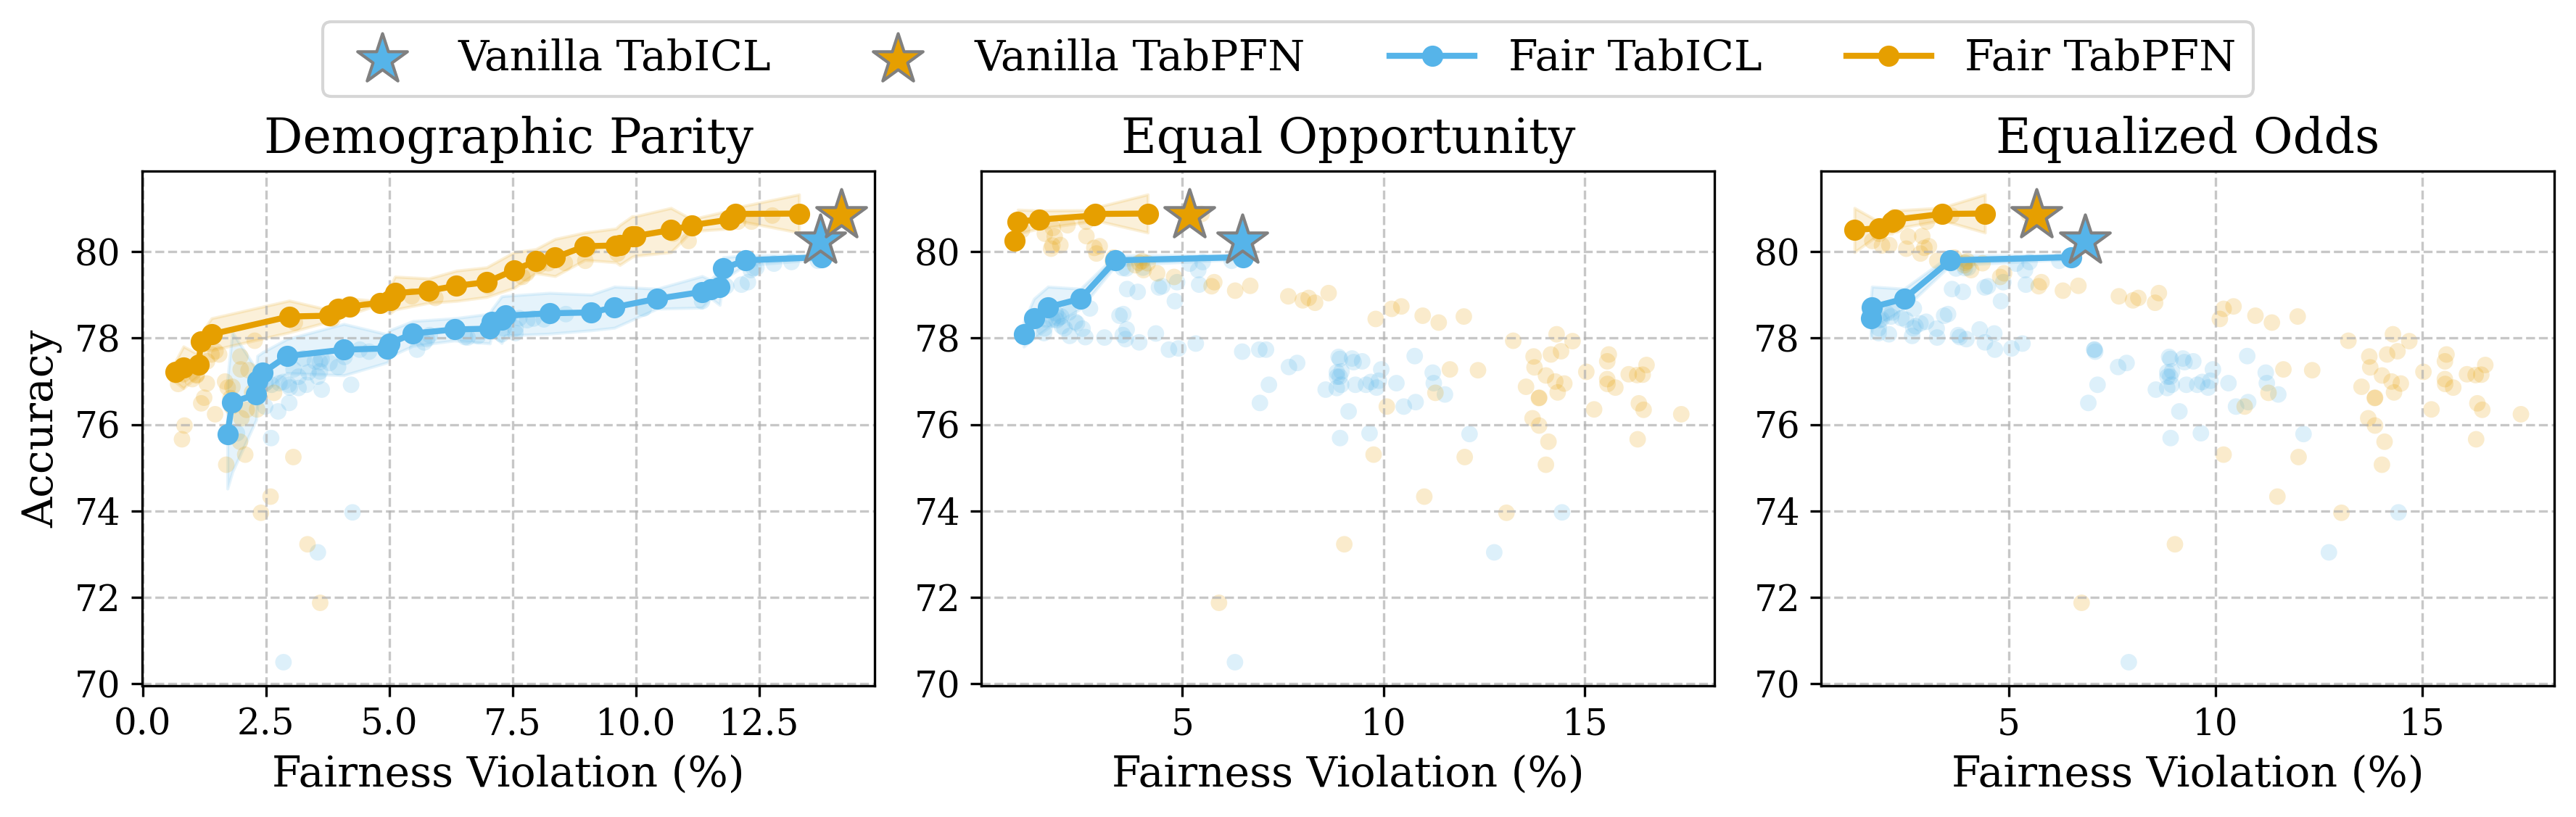

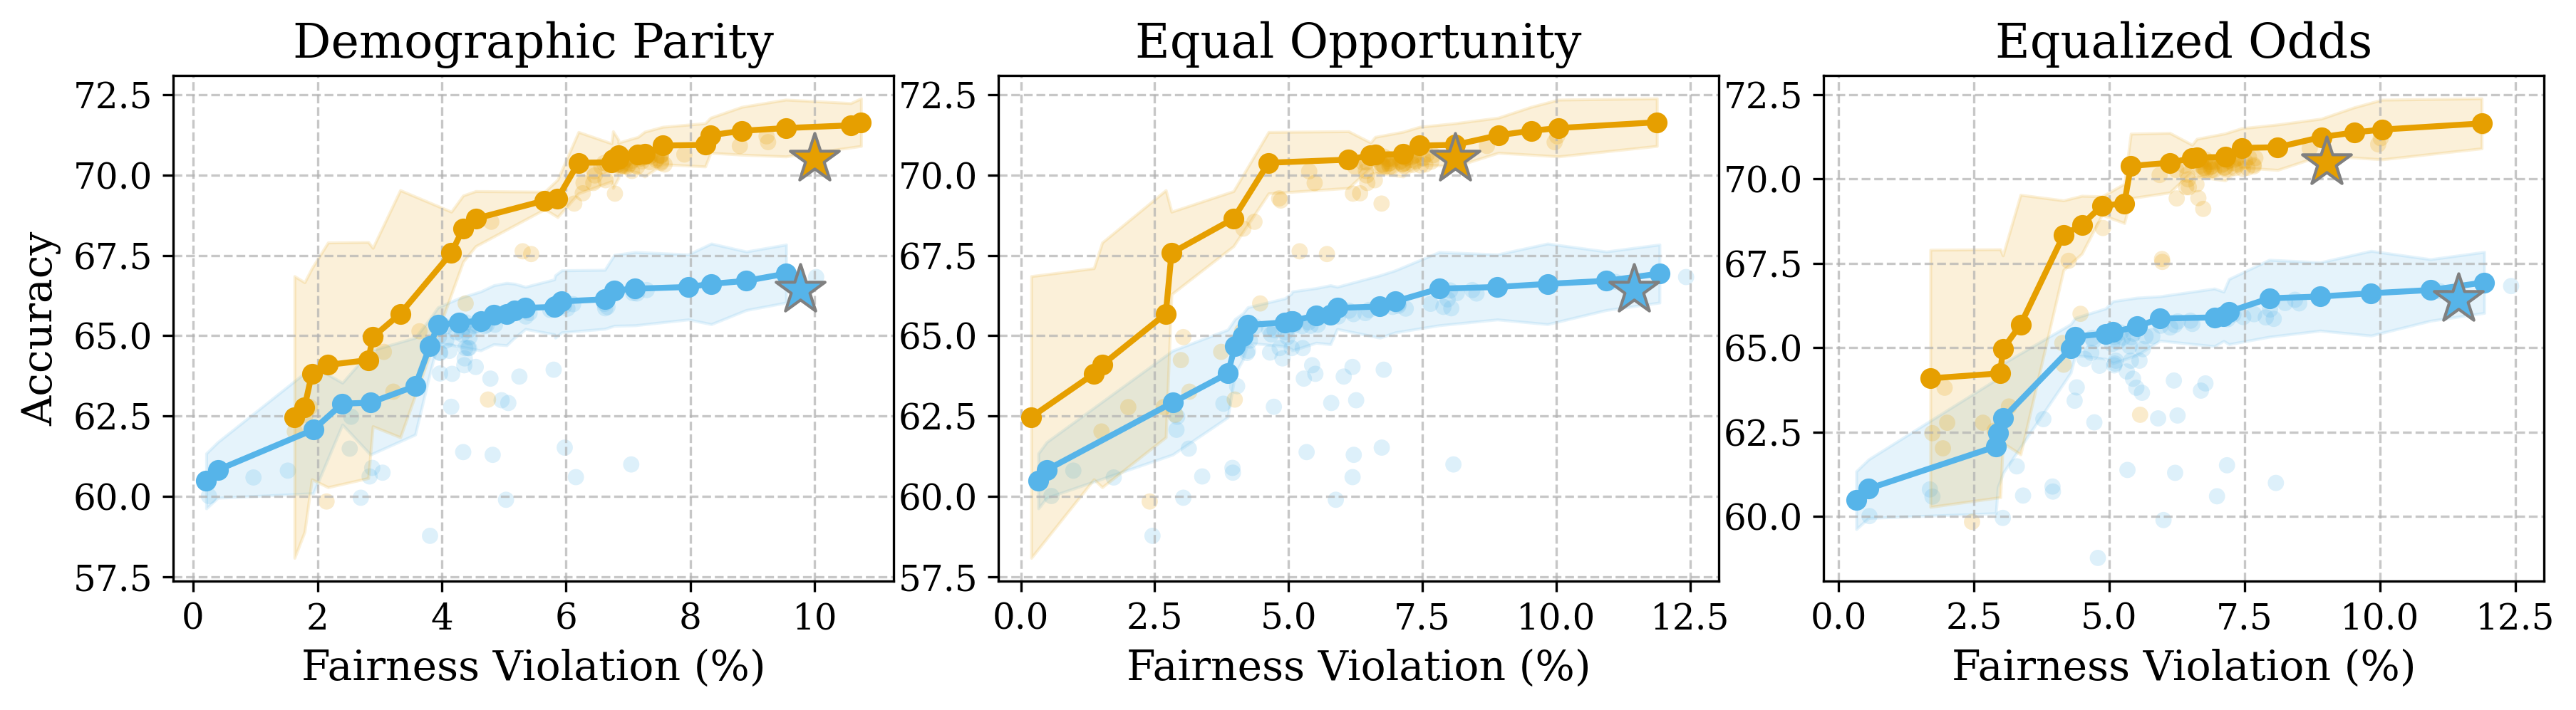

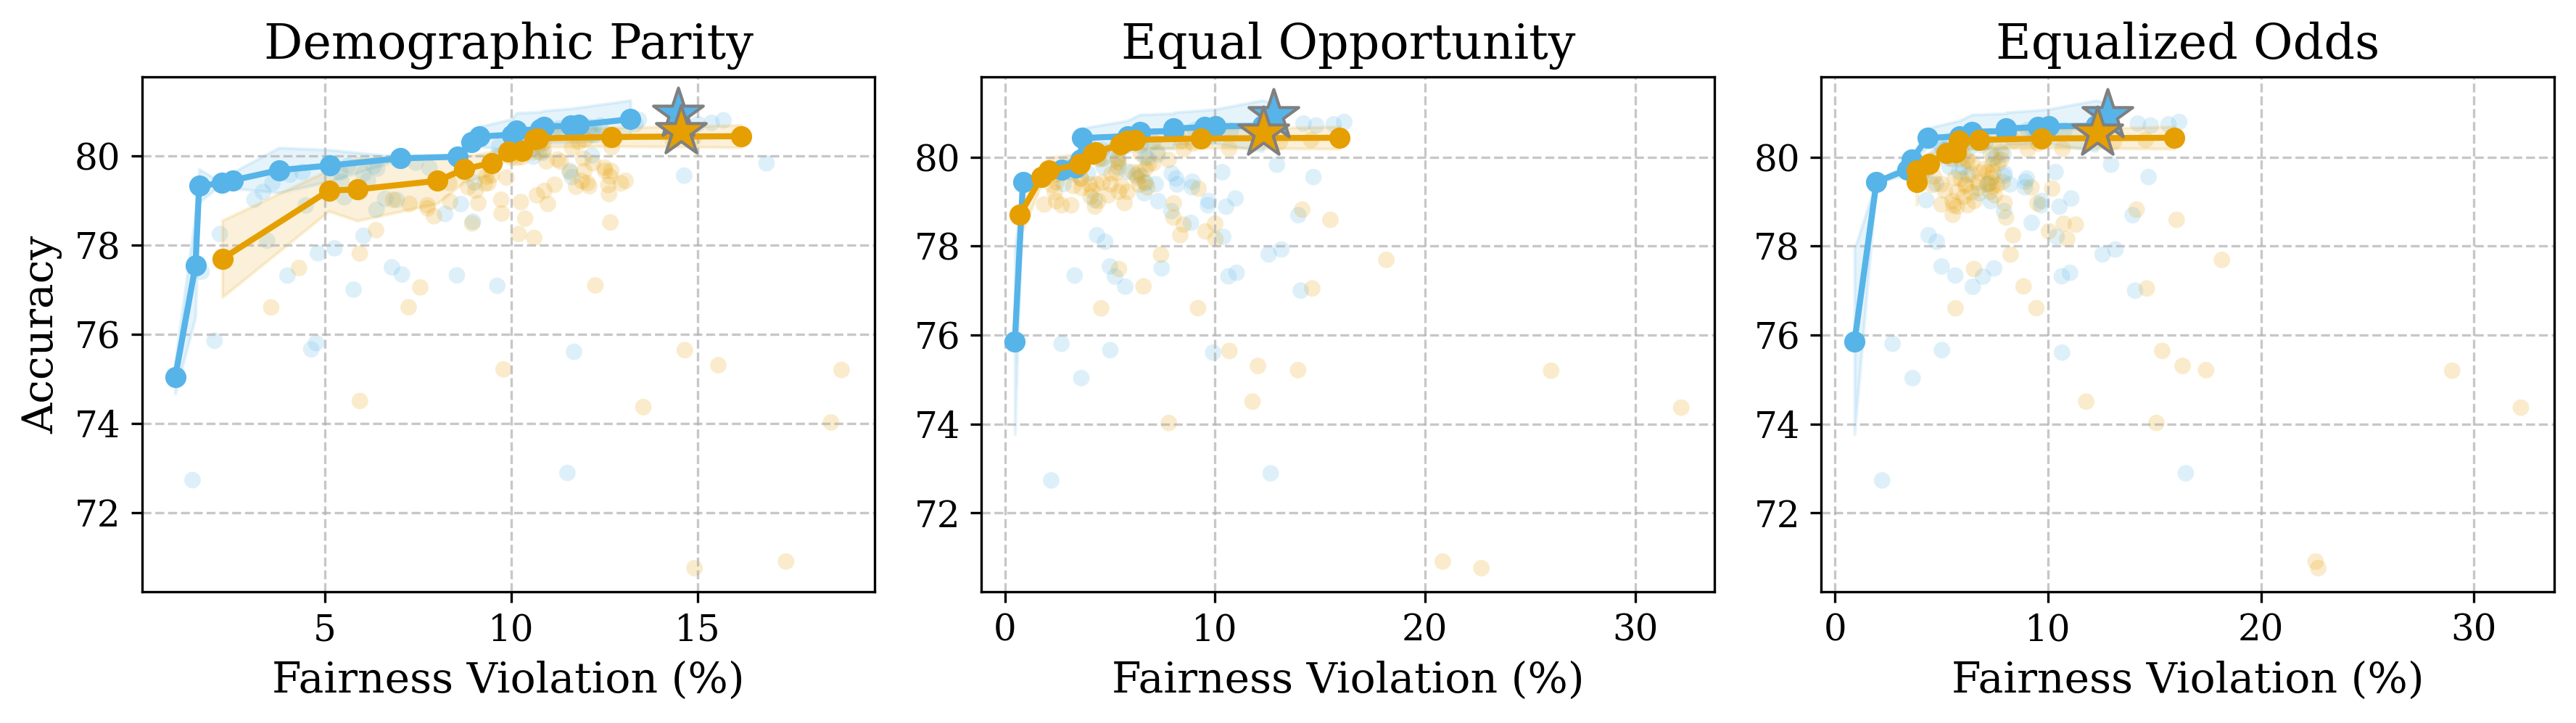

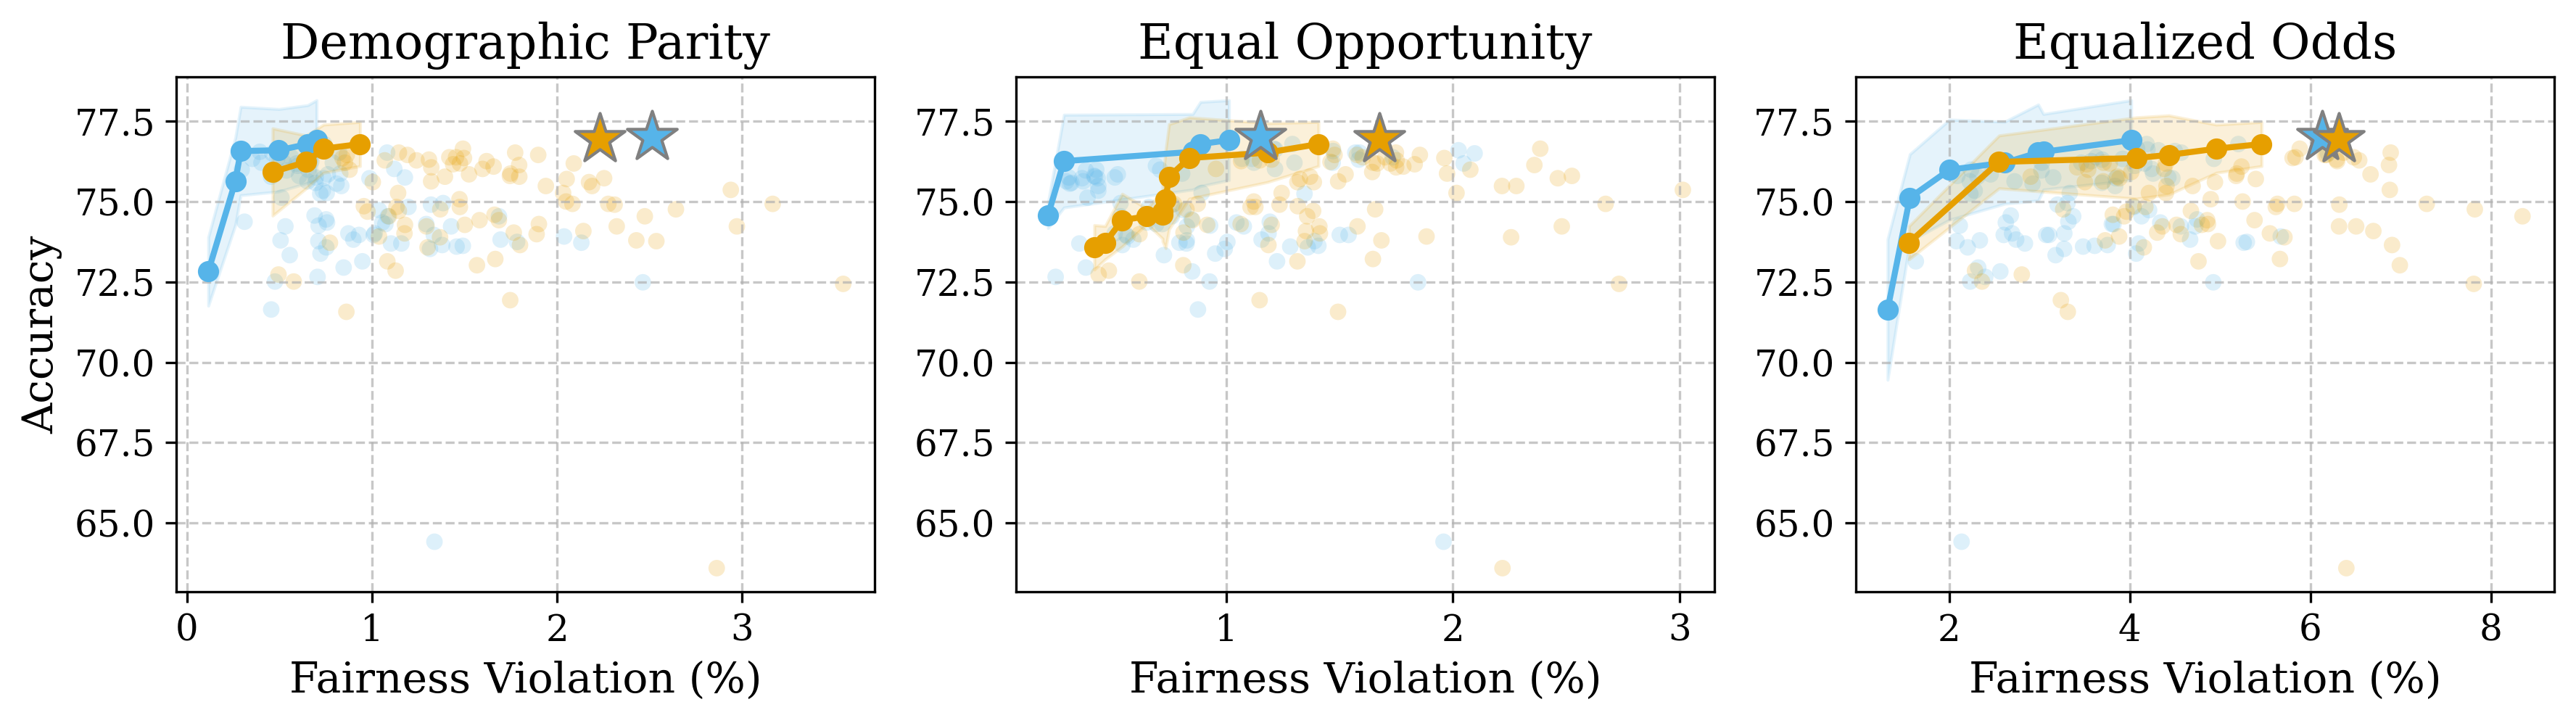

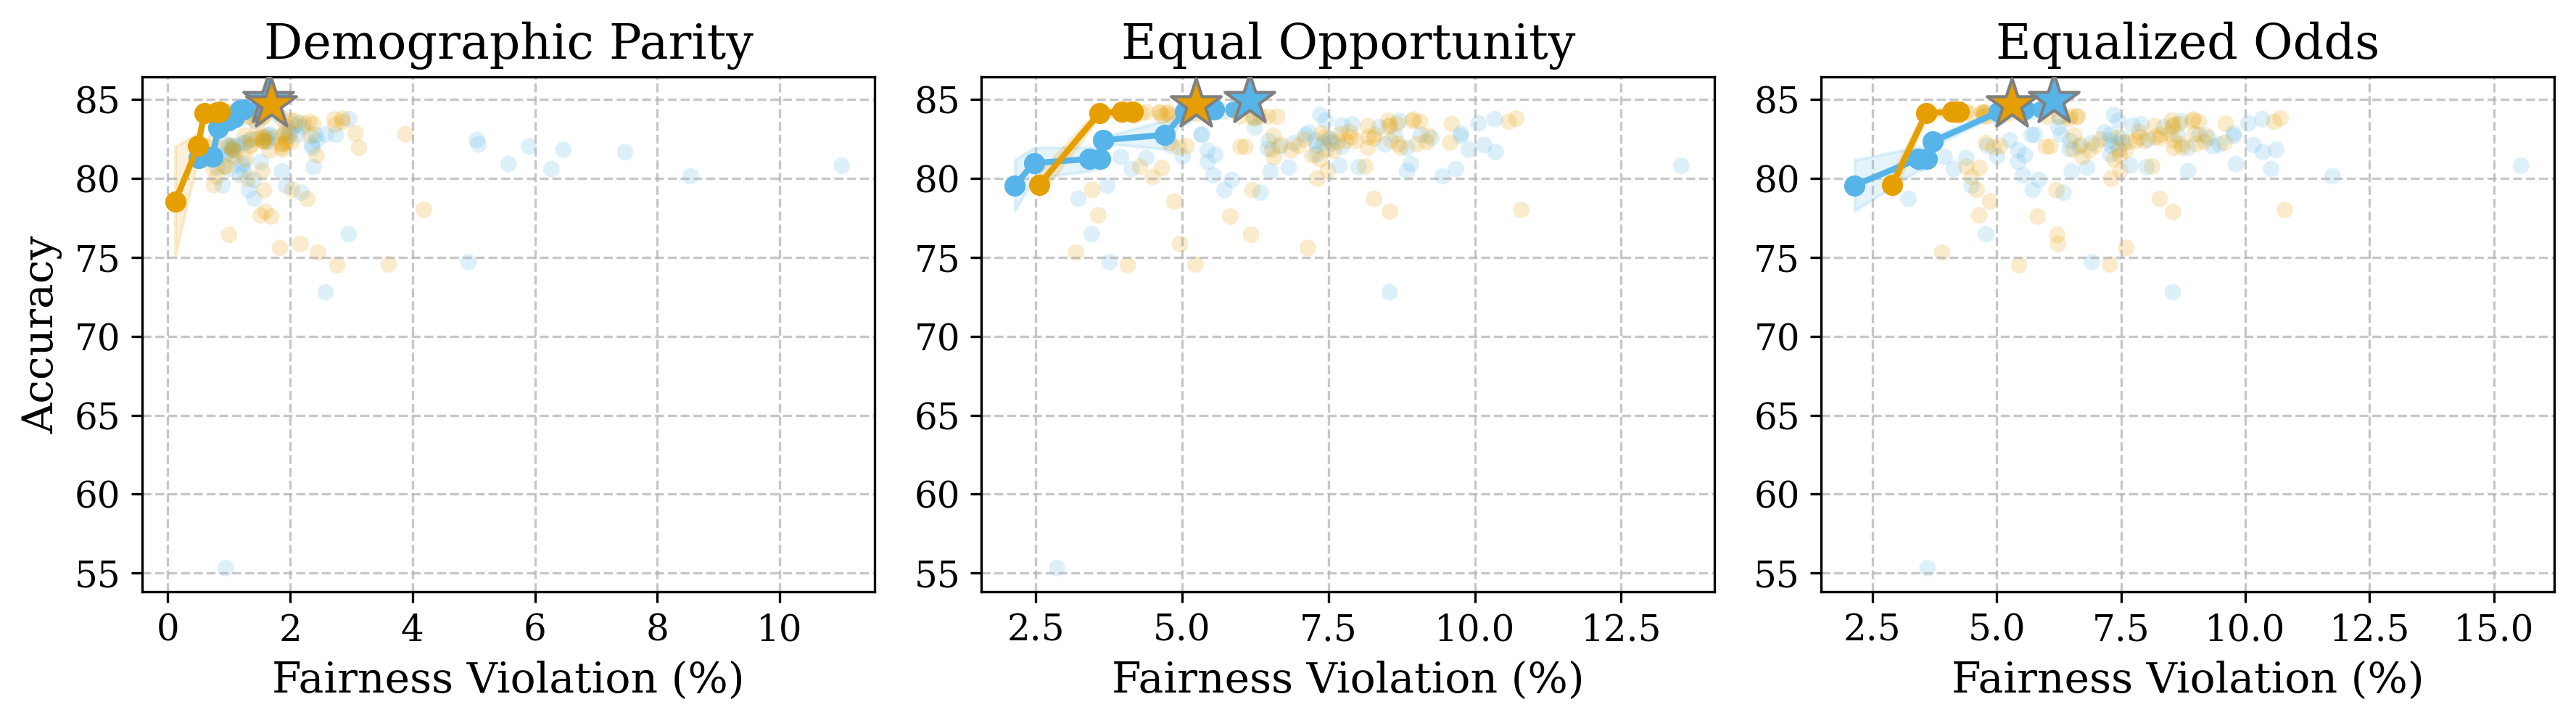

In [27]:
def plot_pareto_front_base_model_comparison(dataset = "adult", method="correlation_remover"):
    path_tabpfn = f"analysis/tradeoff/{dataset}/t_size_-1/tabpfn/{method}"
    path_tabicl = f"analysis/tradeoff/{dataset}/t_size_-1/tabicl/{method}"
    path_vanilla_tabpfn = f"analysis/results/{dataset}/t_size_-1/tabpfn/vanilla"
    path_vanilla_tabicl = f"analysis/results/{dataset}/t_size_-1/tabicl/vanilla"

    df_vanilla_tabpfn = get_merged_df(path_vanilla_tabpfn)
    df_vanilla_tabicl = get_merged_df(path_vanilla_tabicl)

    models = {
        f"Fair TabICL": path_tabicl,
        f"Fair TabPFN": path_tabpfn,
    }
     
    
    def plot_front(averaged_df, fairness_metric, ax, model, color):
        acc_metric = "acc"
        accuracies = averaged_df[acc_metric]
        fairness = averaged_df[fairness_metric] 

        # For Pareto front, we want to maximize accuracy and minimize fairness violation
        errors = 1.0 - accuracies
        pareto_input = np.array([[error, unfair] for (error, unfair) in zip(errors, fairness)])
        
        # Get Pareto efficient points
        is_efficient = is_pareto_efficient(pareto_input)
        pareto_df = averaged_df.iloc[is_efficient].copy()
        
        # Sort by fairness metric for proper line drawing
        pareto_df = pareto_df.sort_values(by='acc')
        
        # Plot all points with transparency
        ax.scatter(averaged_df[fairness_metric], averaged_df[acc_metric], 
                  alpha=0.2, color=color, s=30, edgecolor='none')
         

         

        # Plot Pareto front with solid line and markers
        ax.plot(pareto_df[fairness_metric], pareto_df[acc_metric], 
               '-o', label=model, linewidth=2, markersize=6, color=color)
        
        # Add error bands for accuracy
        ax.fill_between(
            pareto_df[fairness_metric],
            pareto_df[acc_metric] - pareto_df[acc_metric+"_std"],
            pareto_df[acc_metric] + pareto_df[acc_metric+"_std"],
            alpha=0.15, color=color
        )

        return pareto_df
    
    metrics = ['dp', 'eop', 'eodds']
    metric_labels = ['Demographic Parity', 'Equal Opportunity', 'Equalized Odds']
    
    # Set up figure with better aesthetics
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
    
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 14,
        'figure.dpi': 300,
        'savefig.dpi': 300
    })
    
    colors = ['#56B4E9', '#E69F00', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, (model, path) in enumerate(models.items()):
        averaged = get_averaged_df(path) 
        for ax_idx, (ax, metric, metric_label) in enumerate(zip(axes, metrics, metric_labels)):
            if i == 0:
                for j,  (name, df) in enumerate(zip(["Vanilla TabICL", "Vanilla TabPFN"], [df_vanilla_tabicl, df_vanilla_tabpfn])):
                    mean_acc = df['acc'].mean()
                    mean_metric = df[metric].mean()
                    # Plot star marker for random baseline
                    ax.scatter(mean_metric , mean_acc, marker='*', s=300, 
                                color=colors[j], edgecolor='gray', label=name if ax_idx == 0 else None, zorder=10)
            plot_front(averaged, metric, ax, model, colors[i])
            
            # Improve axis labels and appearance 
            ax.set_xlabel(f"Fairness Violation (%)")
            if ax_idx == 0:
                ax.set_ylabel("Accuracy")
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.set_title(metric_label)
            
            
    # Add a common legend at the bottom
    handles, labels = axes[0].get_legend_handles_labels()
    
    if dataset=="adult_income":
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), 
                ncol=len(models)+2, frameon=True, fancybox=True)  
        
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    
    # Save figure with high quality
    #plt.savefig(f"plots/tabicl_vs_tabpfn/pareto_tabicl_vs_tabpfn_{method}_{dataset}.pdf", bbox_inches='tight')
    

datasets = ["adult_income", "travel", "celeba_attract", "mobility", "coverage"]
for dataset in datasets:
    #plot_pareto_front_base_model_comparison(dataset=dataset, method="correlation_remover") 
    plot_pareto_front_base_model_comparison(dataset=dataset, method="uncertain_tabpfn") 
   

### Ablation on Context Size

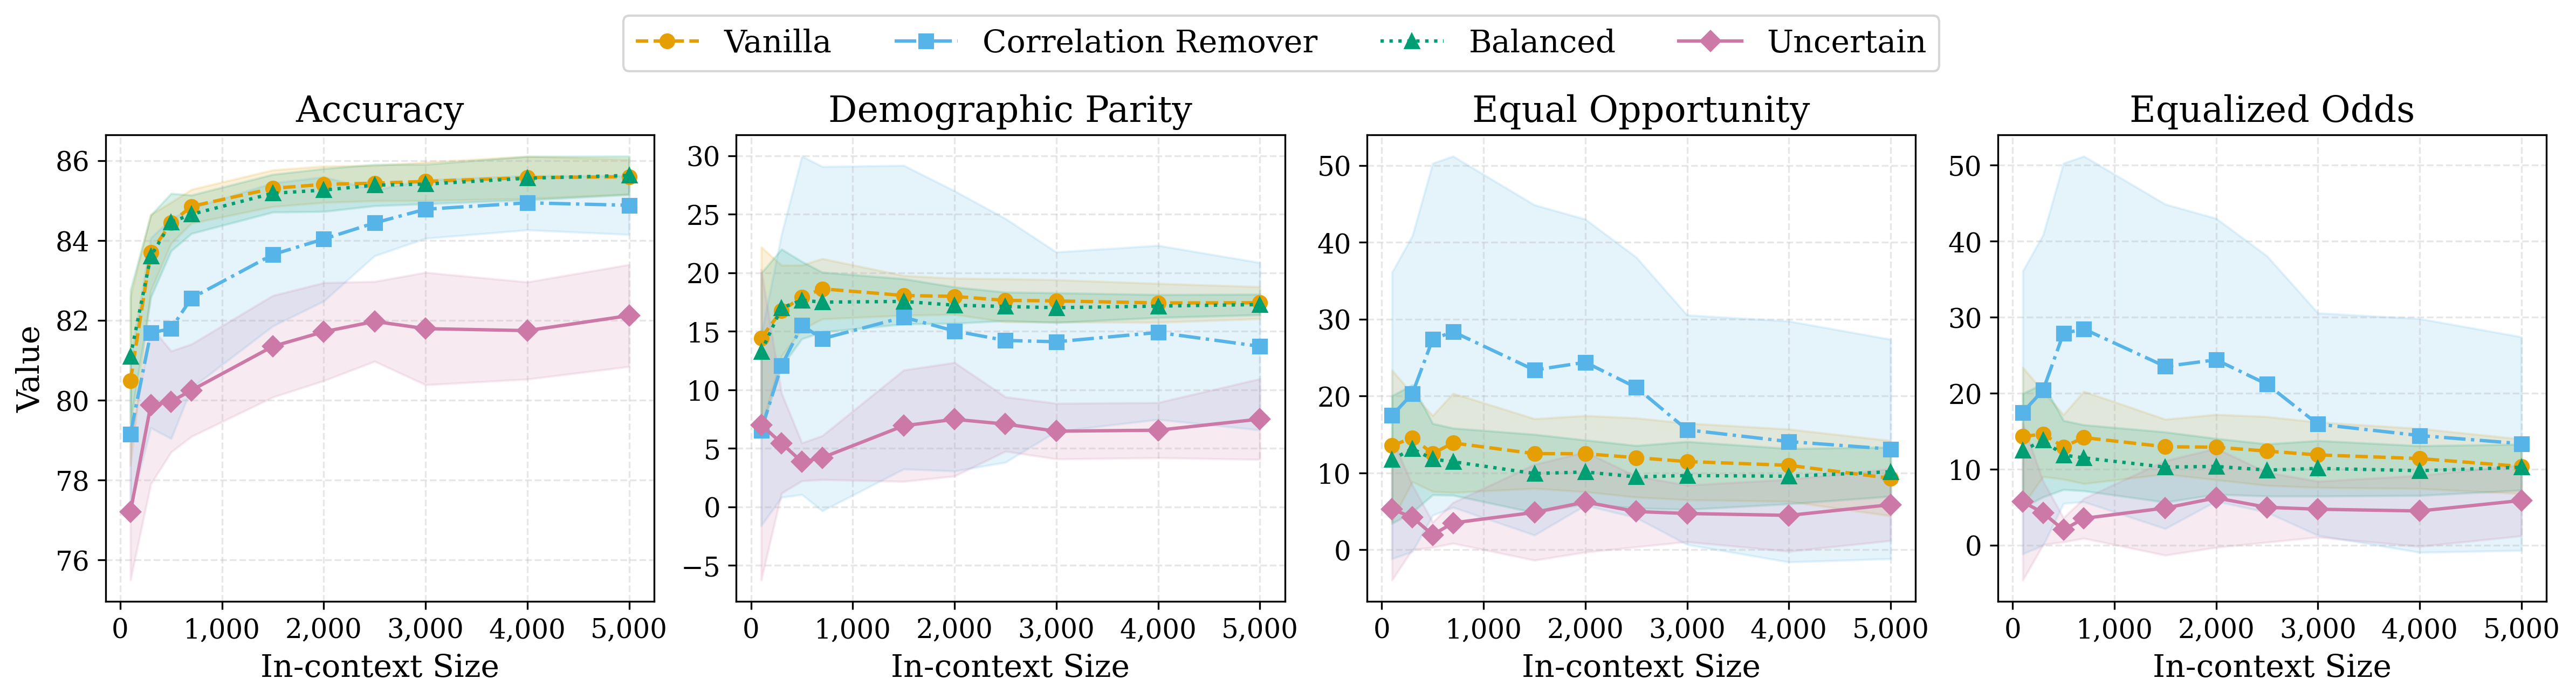

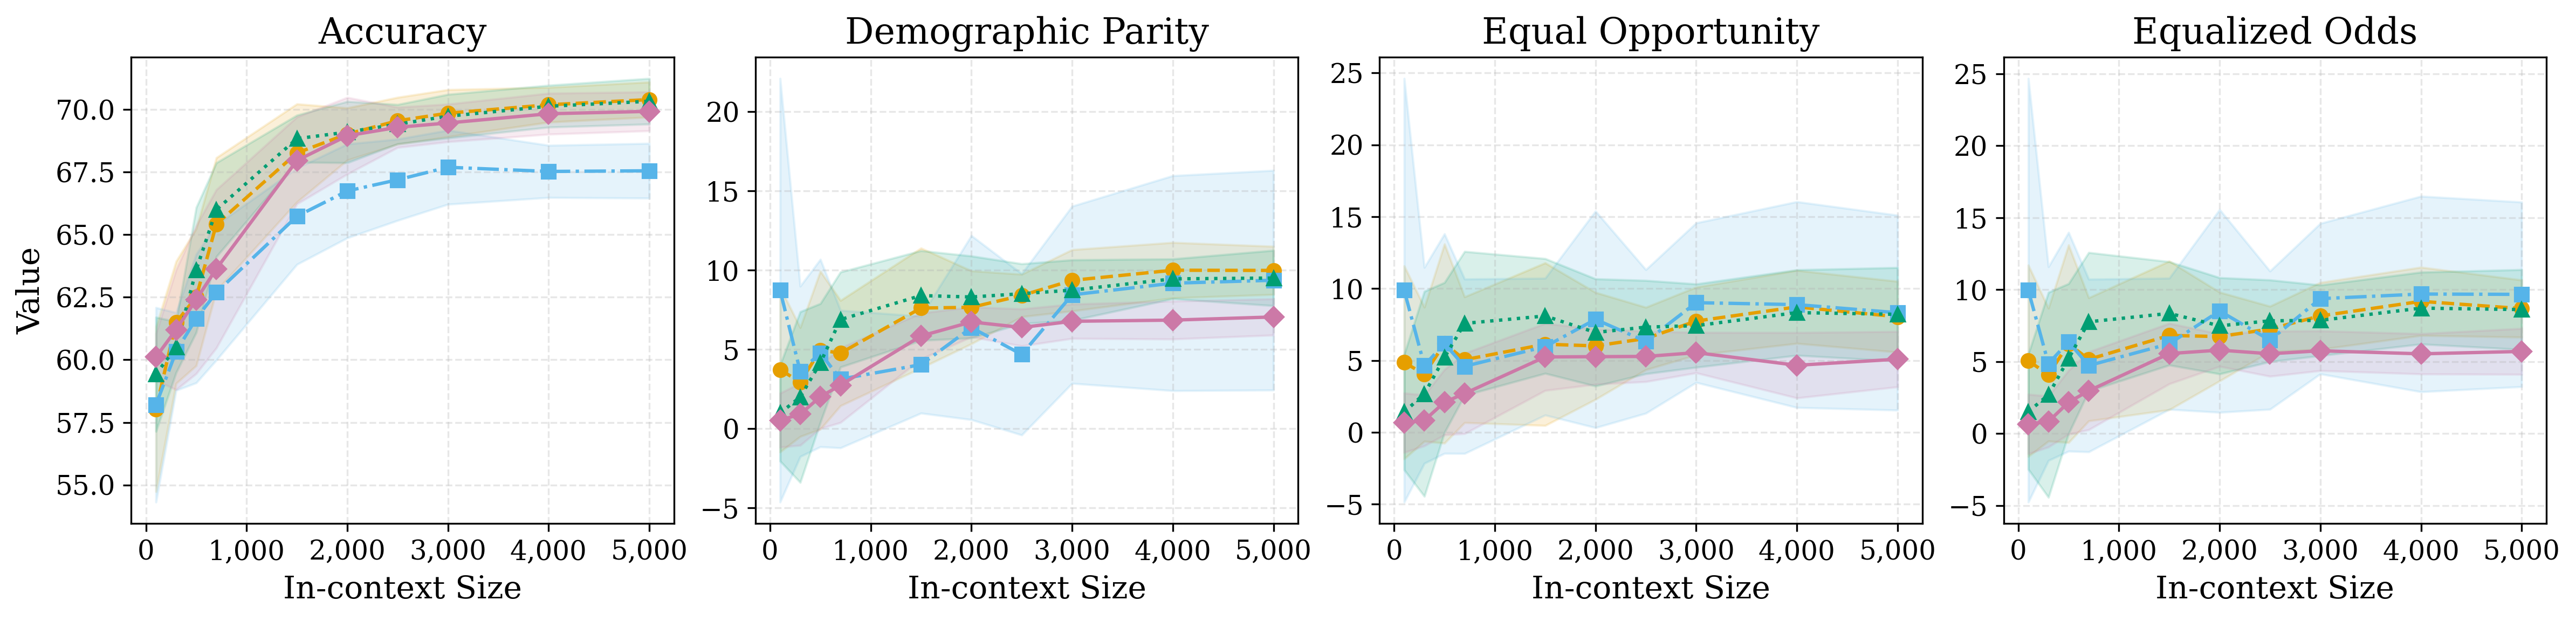

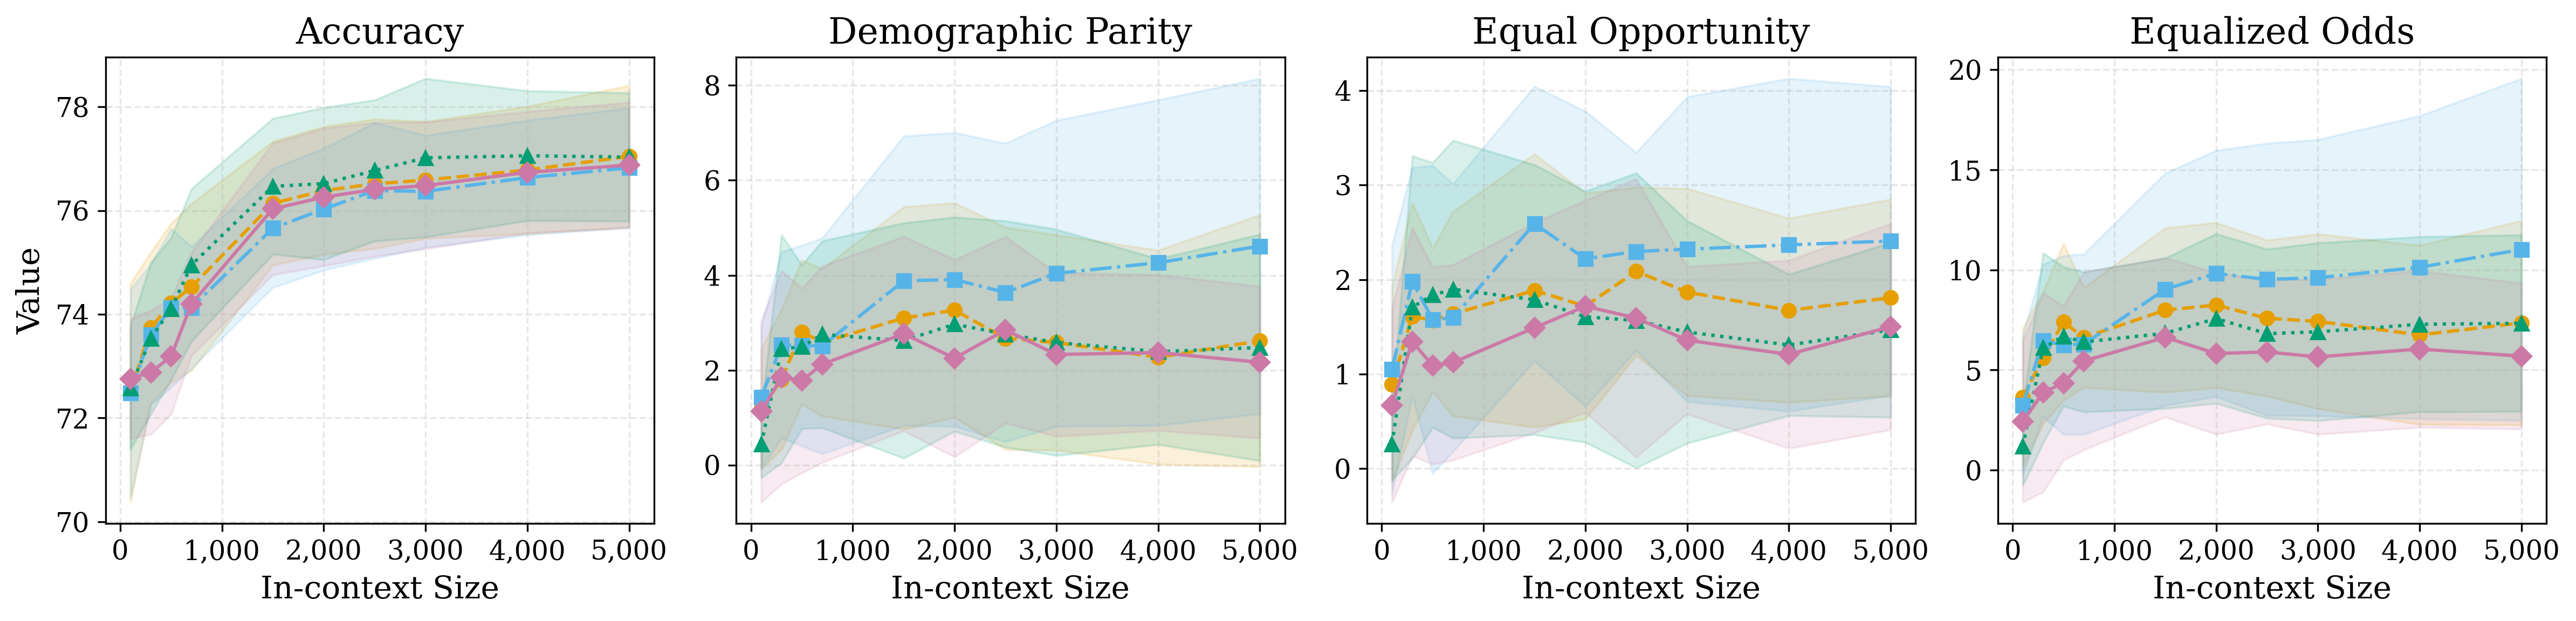

In [36]:
def plot_ablation_tsize(dataset, t_sizes=[100, 250, 500, 1000, 2000], base_model="tabicl", cp=0.05, uncertain=True, uncertainty_model="tabpfn"): 
    """
    Plot ablation study comparing different methods across training sizes.
    
    Args:
        dataset: Name of the dataset
        t_sizes: List of training sizes to evaluate
        base_model: Model type to use
        cp: Conformal prediction alpha value
        uncertain: Whether to use uncertainty sampling
    """
    # Set publication-quality figure parameters
    plt.rcParams.update({
        'font.family': 'serif',
        'font.size': 12,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 14,
        'figure.dpi': 300,
        'savefig.dpi': 300
    })
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Dictionary to store metric values for each method
    metric_values = {}

    if dataset == "celeba_attract":
        cp = 0.9
    
    
    # Collect data for each training size
    for t_size in t_sizes:
        # Define paths for different methods
        uncertainty_base_model = "" if uncertainty_model =="lr" else f"/uncertainty_model_{uncertainty_model}"
        uncertainty_base_model = f"analysis/Ablation/Training_Size/{dataset}/t_size_{t_size}/{base_model}/uncertain/cp_alpha_{cp}{uncertainty_base_model}"
        paths = {
            "uncertain": uncertainty_base_model, 
            "random": f"analysis/Ablation/Training_Size/{dataset}/t_size_{t_size}/{base_model}/random/uncertainty_model_tabpfn",
            "cr": f"analysis/Ablation/Training_Size/{dataset}/t_size_{t_size}/{base_model}/correlation_remover/alpha_1.0/uncertainty_model_tabpfn",
            "balanced": f"analysis/Ablation/Training_Size/{dataset}/t_size_{t_size}/{base_model}/balanced/uncertainty_model_tabpfn"
        }
        
        # Load dataframes for each method
        dfs = {method: get_merged_df(path) for method, path in paths.items()}
        
        # Extract metrics for each method
        for metric in metrics:
            # Initialize metric dictionaries if they don't exist
            for method in dfs.keys():
                metric_key = f"{metric}_{method}" if method != "uncertain" else metric
                if metric_key not in metric_values:
                    metric_values[metric_key] = {'mean': [], 'std': []}
                
                # Store mean and std values
                metric_values[metric_key]['mean'].append(dfs[method].mean()[metric])
                metric_values[metric_key]['std'].append(dfs[method].std()[metric])
    
    # Define method properties for plotting - using colorblind-friendly palette
    methods = [
        {"name": "random", "label": "Vanilla", "marker": "o", "color": "#E69F00", "linestyle": "--"},
        {"name": "cr", "label": "Correlation Remover", "marker": "s", "color": "#56B4E9", "linestyle": "-."},
        {"name": "balanced", "label": "Balanced", "marker": "^", "color": "#009E73", "linestyle": ":"},
        {"name": "uncertain", "label": "Uncertain", "marker": "D", "color": "#CC79A7", "linestyle": "-"}, 
    ]
    
    # Plot each metric
    for ax_idx, (ax, metric) in enumerate(zip(axes, metrics)):
        for method in methods:
            method_name = method["name"]
            metric_key = f"{metric}_{method_name}" if method_name != "uncertain" else metric
            
            # Only show label in the first plot
            label = method["label"] if ax_idx == 0 else None
            
            mean = metric_values[metric_key]['mean']
            std = metric_values[metric_key]['std']
            
            # Plot line with error bands
            
            ax.plot(t_sizes, mean, marker=method['marker'], linestyle=method['linestyle'], 
                   linewidth=1.5, markersize=6, label=label, color=method["color"])
            ax.fill_between(t_sizes,
                           [m - s for m, s in zip(mean, std)],
                           [m + s for m, s in zip(mean, std)],
                           alpha=0.15, color=method["color"])

        # Set plot styling
        ax.set_title(metric_names[metric])
        ax.set_xlabel("In-context Size")
        if metric == "acc":
            ax.set_ylabel("Value")
        ax.grid(True, linestyle='--', alpha=0.3)
        
        # Format x-axis with comma separators for thousands
        ax.get_xaxis().set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
       
          

    # Add legend outside the plots for better visibility
    handles, labels = axes[0].get_legend_handles_labels()
    if dataset=='adult_income':
        fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), 
            ncol=4, frameon=True, fancybox=True)
    
    # Adjust layout to minimize empty space
    plt.tight_layout()
    plt.subplots_adjust( wspace=0.15)
    
    # Save figure with high quality
    #plt.savefig(f"plots/ablation/ablation_tsize_{dataset}_{base_model}.pdf", format="pdf", bbox_inches="tight", dpi=300)
     
 
t_sizes=[100, 300, 500, 700, 1500, 2000, 2500, 3000, 4000, 5000] 
base_model="tabpfn" 
datasets = ["adult_income", "travel", "mobility"]
#datasets = ["diabetes_race"]
for dataset in datasets:
    plot_ablation_tsize(dataset=dataset, t_sizes=t_sizes, base_model=base_model)    